Ways to improve accuracy:
- Change number of games used to calculate rolling average
- You could search backwards through feature selection
- Change the number of seasons to look previously through
- Incorporate players dataset
- Look into finding team vs team performance in their last x matches

Players Dataset:
- Name
- stats
- performance in last 10 games
- performance against next team in last x games played against them

In [10]:
import pandas as pd

df = pd.read_pickle('data/df_nba_games.pkl')

In [11]:
df.head()

mp        fg       fga       fg%        3p       3pa       3p%        ft  \
0  0.0  0.279070  0.269231  0.347087  0.259259  0.372549  0.361702  0.409091   
1  0.0  0.325581  0.326923  0.368932  0.111111  0.333333  0.168576  0.522727   
2  0.0  0.325581  0.230769  0.434466  0.259259  0.313725  0.412439  0.477273   
3  0.0  0.302326  0.403846  0.293689  0.259259  0.392157  0.346972  0.409091   
4  0.0  0.604651  0.384615  0.667476  0.444444  0.392157  0.603928  0.272727   

        fta       orb  ...  tov%_max_opp_10_y  usg%_max_opp_10_y  \
0  0.433962  0.357143  ...           0.184783           0.112113   
1  0.547170  0.285714  ...           0.282609           0.143041   
2  0.603774  0.357143  ...           0.320652           0.408505   
3  0.396226  0.535714  ...           0.275000           0.219072   
4  0.264151  0.250000  ...           0.581522           0.256443   

   ortg_max_opp_10_y  drtg_max_opp_10_y  total_opp_10_y  home_opp_10_y  \
0           0.510204           0.477778        0.663158            0.0   
1           0.229592           0.622222        0.494737            1.0   
2           0.395408           0.377778        0.421053            0.5   
3           0.265306           0.455556        0.536842            1.0   
4           0.551020           0.233333        0.515789            1.0   

   won_10_y  season_10_y  team_opp_next_y  team_y  
0       0.0       2024.0              PHO     UTA  
1       1.0       2024.0              LAL     SAC  
2       0.5       2024.0              ORL     LAL  
3       0.0       2024.0              POR     PHI  
4       0.0       2024.0              GSW     HOU  

[5 rows x 417 columns]

## Feature Selection

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import accuracy_score

In [13]:
def backtest(data, model, predictors, start=1, step=1):
    all_predictions = []
    
    seasons = sorted(data["season"].unique())
    
    for i in range(start, len(seasons), step):
        season = seasons[i]
        
        train = data[data["season"] < season]
        test = data[data["season"] == season]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        
        combined = pd.concat([test["target"],preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [14]:
def get_predictors(model,n_features=30,direction="forward"):
    split = TimeSeriesSplit(n_splits=3)

    print("Getting predictors...")
    sfs = SequentialFeatureSelector(model, n_features_to_select=n_features, direction=direction, cv=split)
    sfs.fit(df[selected_columns], df["target"])
    
    predictors = list(selected_columns[sfs.get_support()])
    print(f"{len(predictors)} predictors found")
    return predictors

In [15]:
removed_columns = list(df.columns[df.dtypes == "object"]) + ["season", "date", "won", "target", "team", "team_opp"]
selected_columns = df.columns[~df.columns.isin(removed_columns)]

In [16]:
rr = RidgeClassifier(alpha=1)
predictors = get_predictors(rr,n_features=30,direction="backward")
predictions = backtest(df, rr, predictors)
accuracy_score(predictions["actual"], predictions["prediction"])

Getting predictors...
30 predictors found


0.6622773044151821

In [17]:
predictors

['drb',
 'blk',
 'pf',
 'ts%',
 'ast_opp',
 'ts%_opp',
 'usg%_max_opp',
 '3par_10_x',
 'tov%_10_x',
 'ast_max_10_x',
 '+/-_max_10_x',
 'efg%_max_10_x',
 'drb%_max_10_x',
 'drb_opp_10_x',
 'fg%_max_opp_10_x',
 'ts%_max_opp_10_x',
 'total_opp_10_x',
 'home_next',
 'tov%_10_y',
 'orb_max_10_y',
 'ast_max_10_y',
 'gmsc_max_10_y',
 '+/-_max_10_y',
 'ortg_max_10_y',
 'ft_opp_10_y',
 'drb_opp_10_y',
 '3par_opp_10_y',
 'fg%_max_opp_10_y',
 'ts%_max_opp_10_y',
 'total_opp_10_y']

# Model Training
## Fundamental Model Functions

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, mean_absolute_error, mean_squared_error, r2_score, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

In [19]:
# -----------------------------
# 1. Data Preparation
# -----------------------------
def prepare_train_test(df, feature_cols, target_col, test_size=0.3, random_state=42):
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

In [20]:
# -----------------------------
# 2. Model Training & Prediction
# -----------------------------
def train_and_predict(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred

In [21]:
# -----------------------------
# 3. Probability / Score Calculation
# -----------------------------
def get_model_scores(model, X_test):
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)
        y_prob = MinMaxScaler().fit_transform(scores.reshape(-1,1)).ravel()
    return y_prob

In [22]:
# -----------------------------
# 4. Feature Importance
# -----------------------------
def compute_feature_importance(model, X_test, y_test, feature_cols, model_name="Model"):
    """
    Compute feature importance or coefficients for any model type.
    Handles:
      - Linear models (with coef_) — normalized 0–1
      - Logistic regression (adds Odds Ratios)
      - Tree-based models (with feature_importances_)
      - Other models via normalized permutation importance
    """
    is_logistic = False

    # --- 1. Linear / Logistic Models ---
    if hasattr(model, "coef_"):
        coef = model.coef_
        # Handle both 1D and 2D arrays safely
        if coef.ndim > 1:
            coef = coef[0]

        importance_vals = np.abs(coef)
        # ✅ Normalize to 0–1 range (avoid divide-by-zero)
        importance_vals = (importance_vals - importance_vals.min()) / (importance_vals.max() - importance_vals.min() + 1e-9)

        feature_importance = pd.DataFrame({
            "Feature": feature_cols,
            "Coefficient": coef,
            "Importance": importance_vals
        }).sort_values(by="Importance", ascending=False)

        # Detect logistic regression automatically
        if hasattr(model, "predict_proba") and "logistic" in model.__class__.__name__.lower():
            is_logistic = True
            feature_importance["Odds Ratio"] = np.exp(coef)

    # --- 2. Tree-based Models ---
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        # Normalize to 0–1
        importances = importances / (importances.max() + 1e-9)
        feature_importance = pd.DataFrame({
            "Feature": feature_cols,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

    # --- 3. Fallback: Permutation Importance ---
    else:
        perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importances = np.abs(perm.importances_mean)
        importances = (importances - importances.min()) / (importances.max() - importances.min() + 1e-9)  # normalize 0–1

        feature_importance = pd.DataFrame({
            "Feature": feature_cols,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)

    return feature_importance, is_logistic

In [23]:
# -----------------------------
# 5. Metrics Calculation
# -----------------------------
def calculate_metrics(y_test, y_pred, y_prob=None, is_classification=True):
    metrics = {}
    if is_classification:
        metrics["accuracy"] = accuracy_score(y_test, y_pred)
        metrics["classification_report"] = classification_report(y_test, y_pred)
        print(metrics["classification_report"])
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            metrics["fpr"] = fpr
            metrics["tpr"] = tpr
            metrics["auc"] = auc(fpr, tpr)
    else:
        metrics["MAE"] = mean_absolute_error(y_test, y_pred)
        metrics["MSE"] = mean_squared_error(y_test, y_pred)
        metrics["RMSE"] = np.sqrt(metrics["MSE"])
        metrics["R2"] = r2_score(y_test, y_pred)
    return metrics

In [24]:
# -----------------------------
# 6. Dynamic Plotting
# -----------------------------
def plot_dashboard(metrics, y_test, y_pred, y_prob, feature_importance, is_classification, is_logistic, model_name="Model"):
    plots = []

    if is_classification:
        plots.append("Confusion Matrix")
        plots.append("Feature Importance")
        if y_prob is not None:
            plots.append("ROC Curve")
            plots.append("Probability Histogram")
    else:
        plots.extend(["Predicted vs Actual", "Residuals", "Feature Importance"])

    n_plots = len(plots)
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
    if n_rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, plot_name in enumerate(plots):
        ax = axes[i]

        if plot_name == "Confusion Matrix":
            ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                                   display_labels=np.unique(y_test)).plot(ax=ax, colorbar=False)
            ax.set_title("Confusion Matrix")

        elif plot_name == "ROC Curve":
            ax.plot(metrics["fpr"], metrics["tpr"], color="red", label=f"AUC = {metrics['auc']:.2f}")
            ax.plot([0,1],[0,1],'--', color="gray")
            ax.set_title("ROC Curve")
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()

        elif plot_name == "Feature Importance":
            names = feature_importance["Feature"]
            colors = ['orange' if idx < 3 else 'skyblue' for idx in range(len(names))]

            if is_logistic and "Odds Ratio" in feature_importance.columns:
                # Use Odds Ratios instead of generic importance
                values = feature_importance["Odds Ratio"]
                ax.barh(names, values, color=colors)
                ax.axvline(1, color="gray", linestyle="--", linewidth=1)
                ax.set_xscale("log")
                ax.set_xlabel("Odds Ratio (Exp(β)) [log scale]")
                ax.set_title("Odds Ratios by Feature")

                # Optional: label only top few features
                top_n = 5
                for idx, val in enumerate(values[:top_n]):
                    ax.text(val, idx, f"{val:.2f}", va='center', ha='left', fontsize=9, color="black")

            else:
                # Standard feature importance plot
                values = feature_importance["Importance"]
                ax.barh(names, values, color=colors)
                ax.set_xlabel("Normalized Importance (0–1)")
                ax.set_title("Feature Importance")
                for idx, val in enumerate(values):
                    fontweight = 'bold' if idx < 3 else 'normal'
                    ax.text(val + val*0.01, idx, f"{val:.2f}", va='center', fontweight=fontweight)

        elif plot_name == "Probability Histogram":
            ax.hist(y_prob[y_test==1], bins=20, alpha=0.6, label="Class 1", color="green")
            ax.hist(y_prob[y_test==0], bins=20, alpha=0.6, label="Class 0", color="red")
            ax.set_xlabel("Predicted Probability")
            ax.set_ylabel("Frequency")
            ax.legend()
            ax.set_title("Predicted Probability Distribution")

        elif plot_name == "Predicted vs Actual":
            ax.scatter(y_test, y_pred, alpha=0.6)
            ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            ax.set_xlabel("Actual")
            ax.set_ylabel("Predicted")
            ax.set_title("Predicted vs Actual")

        elif plot_name == "Residuals":
            residuals = y_test - y_pred
            ax.hist(residuals, bins=20, color="skyblue")
            ax.set_xlabel("Residual")
            ax.set_ylabel("Frequency")
            ax.set_title("Residuals")

    # Turn off unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f"{model_name} Evaluation Dashboard", fontsize=16, weight="bold")
    plt.show()

In [25]:
# -----------------------------
# 7. Main Dashboard Wrapper
# -----------------------------
def evaluation_dashboard(df, model, feature_cols, target_col, model_name="Model"):
    X_train, X_test, y_train, y_test = prepare_train_test(df, feature_cols, target_col)
    model, y_pred = train_and_predict(model, X_train, X_test, y_train)
    is_classification = hasattr(model, "predict_proba") or hasattr(model, "decision_function") \
                        or (y_train.nunique() <= 10 and pd.api.types.is_integer_dtype(y_train))
    y_prob = get_model_scores(model, X_test)
    feature_importance, is_logistic = compute_feature_importance(model, X_test, y_test, feature_cols, model_name)
    metrics = calculate_metrics(y_test, y_pred, y_prob, is_classification)
    plot_dashboard(metrics, y_test, y_pred, y_prob, feature_importance, is_classification, is_logistic, model_name)
    return model, feature_importance

In [26]:
import joblib
import os

def save_model(model, predictors, feature_importance=None, model_name="model", folder="saved_models"):
    """
    Save a trained scikit-learn model along with predictors and optional feature importance.

    Parameters
    ----------
    model : sklearn estimator
        Trained scikit-learn model
    predictors : list of str
        Exact feature names used for training the model
    feature_importance : pandas Series or dict, optional
        Feature importance for interpretation
    model_name : str
        Name of the file (without extension)
    folder : str
        Folder path to save the model
    """
    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Full file path
    filepath = os.path.join(folder, f"{model_name}.pkl")

    # Prepare dictionary to save
    save_dict = {
        "model": model,
        "predictors": predictors
    }

    if feature_importance is not None:
        save_dict["feature_importance"] = feature_importance

    # Save using joblib
    joblib.dump(save_dict, filepath)

    print(f"Model saved to {filepath}")

## Linear Models

### Linear Regression
__Type__: Regression  
__For__: Predicting continous numeric values (e.g. price, points, sales)  
__Pros__: Simple, interpretable, fast  
__Cons__: Assumes linearity, sensitive to outliers  

Note: Oldest model (1820s-1950s); baseline for regression

In [27]:
from sklearn.linear_model import LinearRegression

def linear_regression(df, x_label, y_label):
    if x_label not in df or y_label not in df: 
        raise Error("Labels not in dataset")
    
    # Enable interactive plotting in Jupyter
    %matplotlib notebook
    
    # Select feature (as 2D array) and target
    X = df[[x_label]]  # double brackets
    y = df[y_label]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Plot
    plt.scatter(X_test.values.flatten(), y_test.values, color="blue", label="Actual")
    plt.plot(X_test.values.flatten(), y_pred.flatten(), color="red", linewidth=2, label="Predicted")

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"Linear Regression: {y_label} vs {x_label}")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


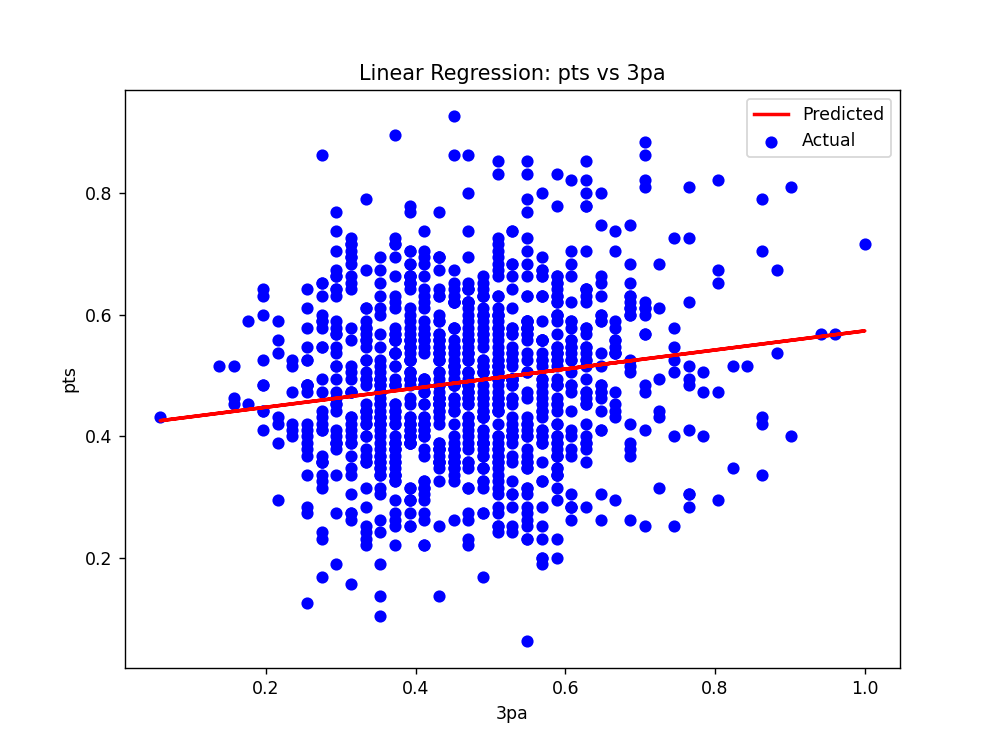

In [28]:
linear_regression(df,"3pa","pts")

<IPython.core.display.Javascript object>


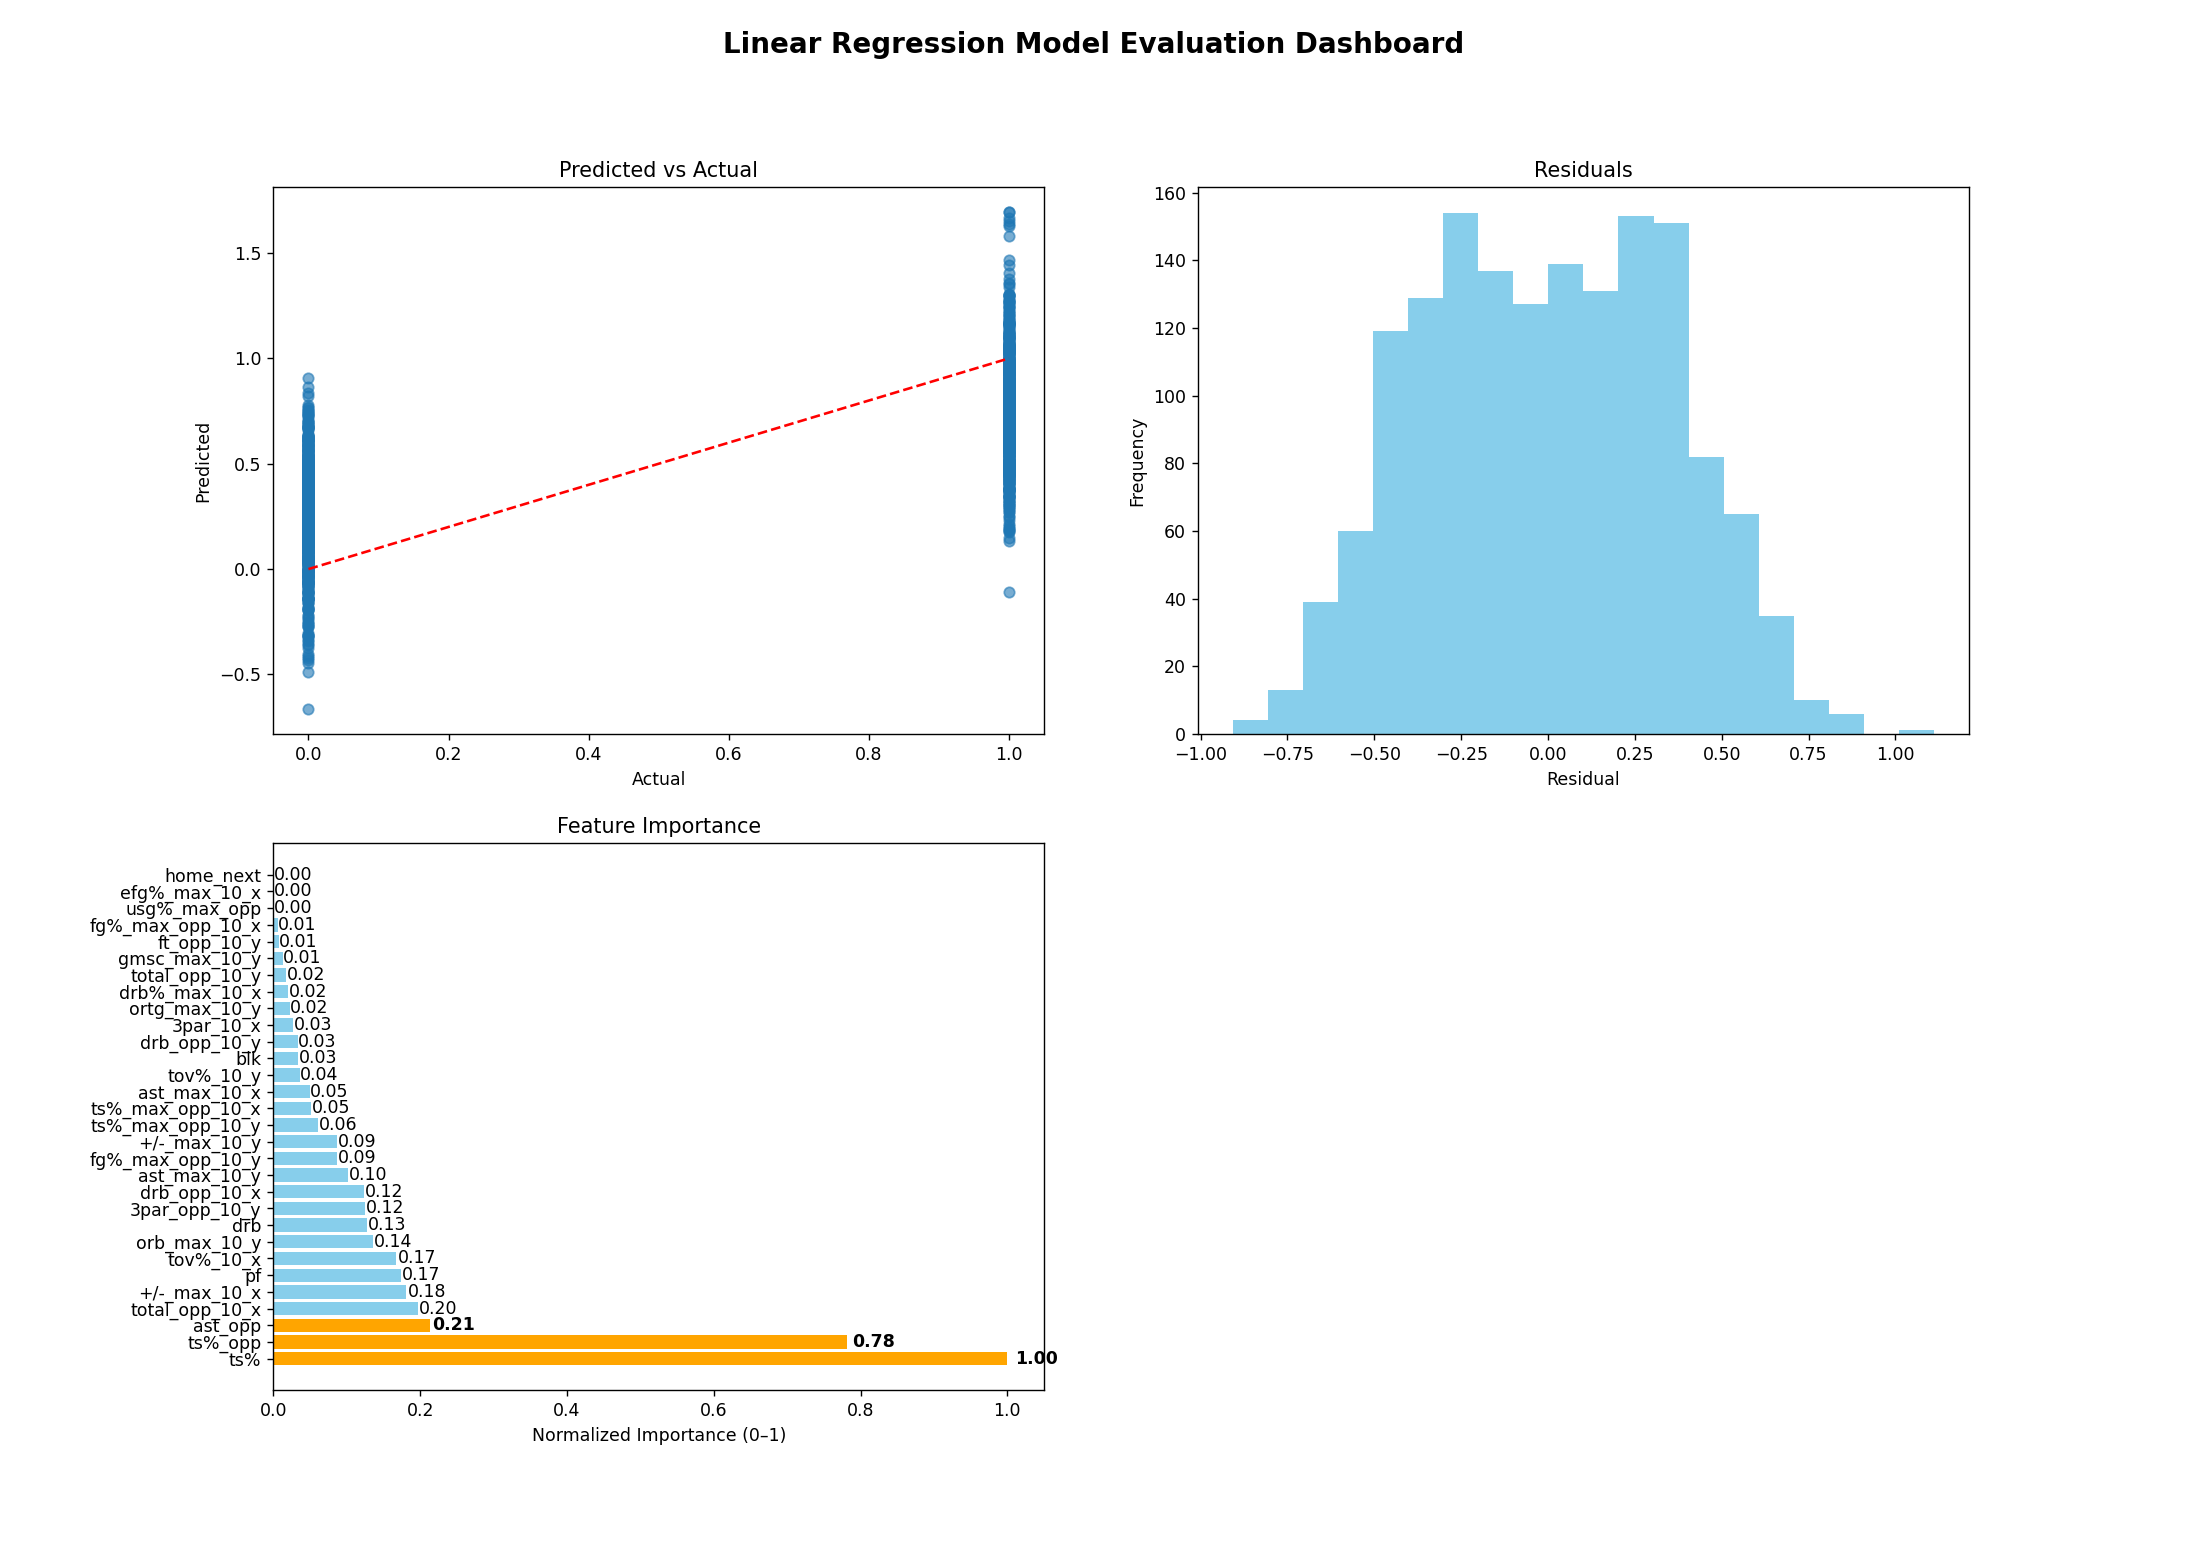

Model saved to saved_models\Linear Regression Model.pkl


In [29]:
model = LinearRegression()
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "Linear Regression Model")
save_model(model, predictors, feature_importance, model_name="Linear Regression Model", folder="saved_models")

### Logistic Regression
__Type__: Classification  
__For__: Binary outcomes (yes/no, win/loss)  
__Pros__: Interpretable, probabilistic output  
__Cons__: Assumes linearity seperability

Note: 1958; still used in finance, medicine, sports

              precision    recall  f1-score   support

       False       0.86      0.85      0.85       765
        True       0.85      0.86      0.86       790

    accuracy                           0.86      1555
   macro avg       0.86      0.86      0.86      1555
weighted avg       0.86      0.86      0.86      1555



<IPython.core.display.Javascript object>


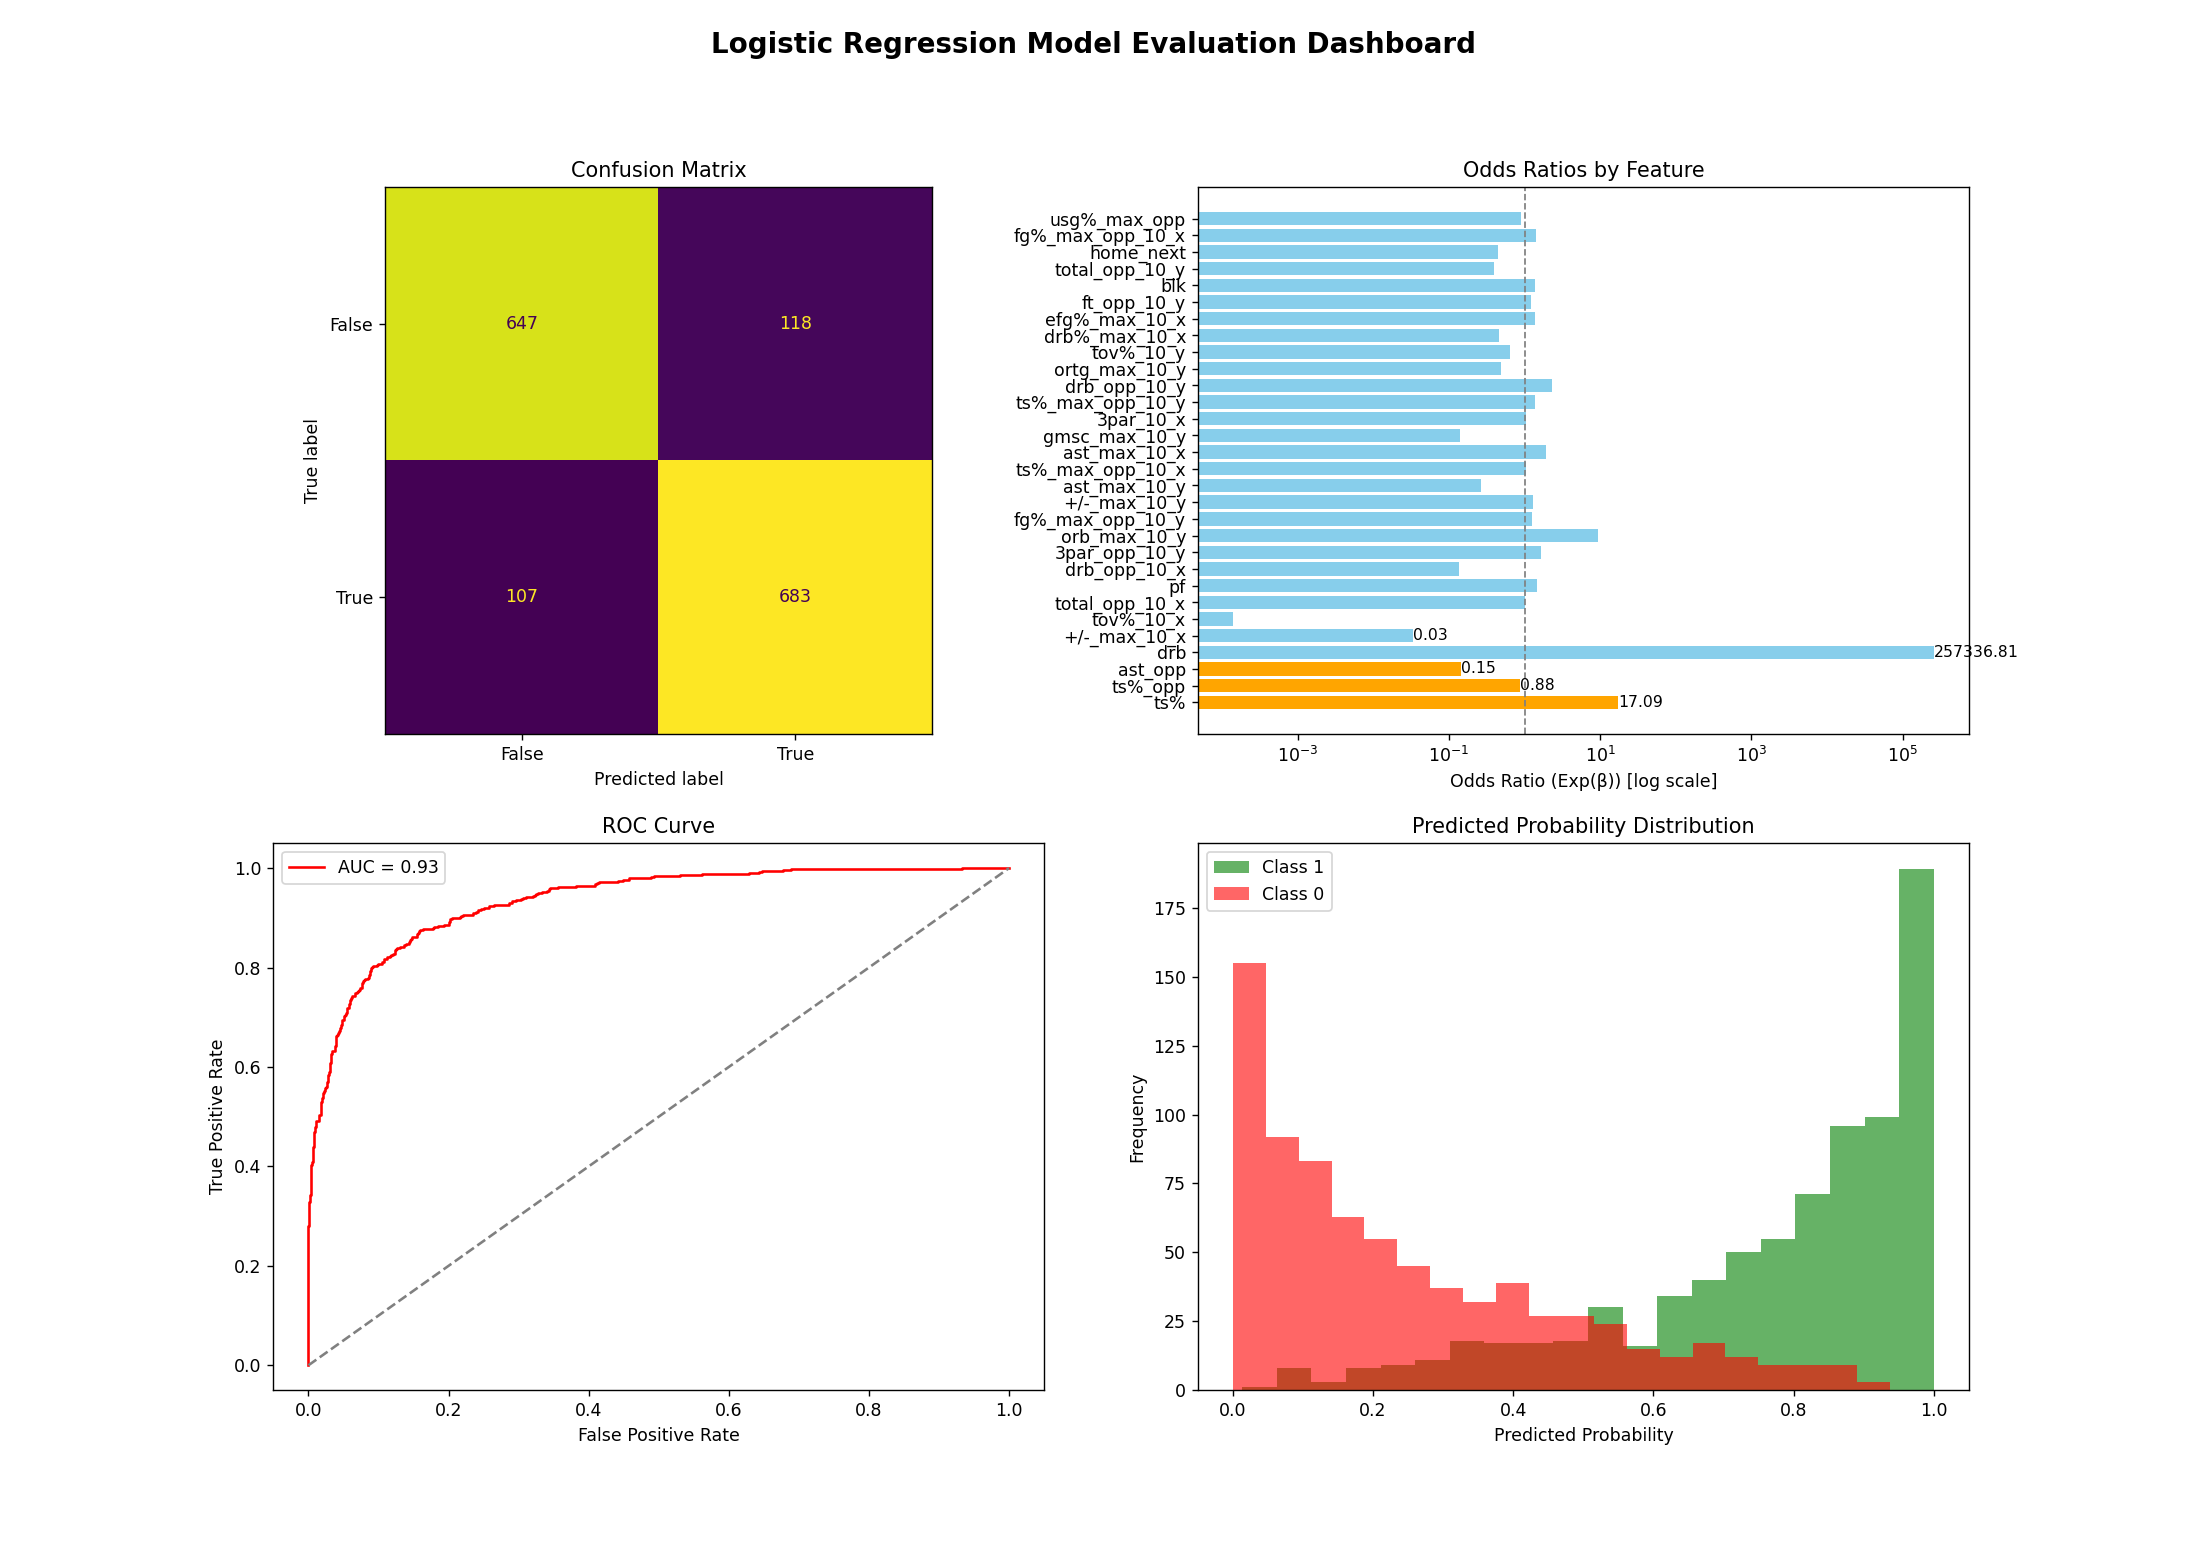

Model saved to saved_models\Logistic Regression Model.pkl


In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model, feature_info = evaluation_dashboard(df, model, predictors, "won", "Logistic Regression Model")
save_model(model, predictors, feature_importance, model_name="Logistic Regression Model", folder="saved_models")

### Support Vector Machine (SVM)
__Type__: Both  
__For__: High-dimensional data  
__Pros__: Works well on small, complex datasets  
__Cons__: Hard to tune, slow on large data

Note: 1992 (Vapnik); great for text or image features

              precision    recall  f1-score   support

       False       0.85      0.84      0.84       765
        True       0.84      0.86      0.85       790

    accuracy                           0.85      1555
   macro avg       0.85      0.85      0.85      1555
weighted avg       0.85      0.85      0.85      1555



<IPython.core.display.Javascript object>


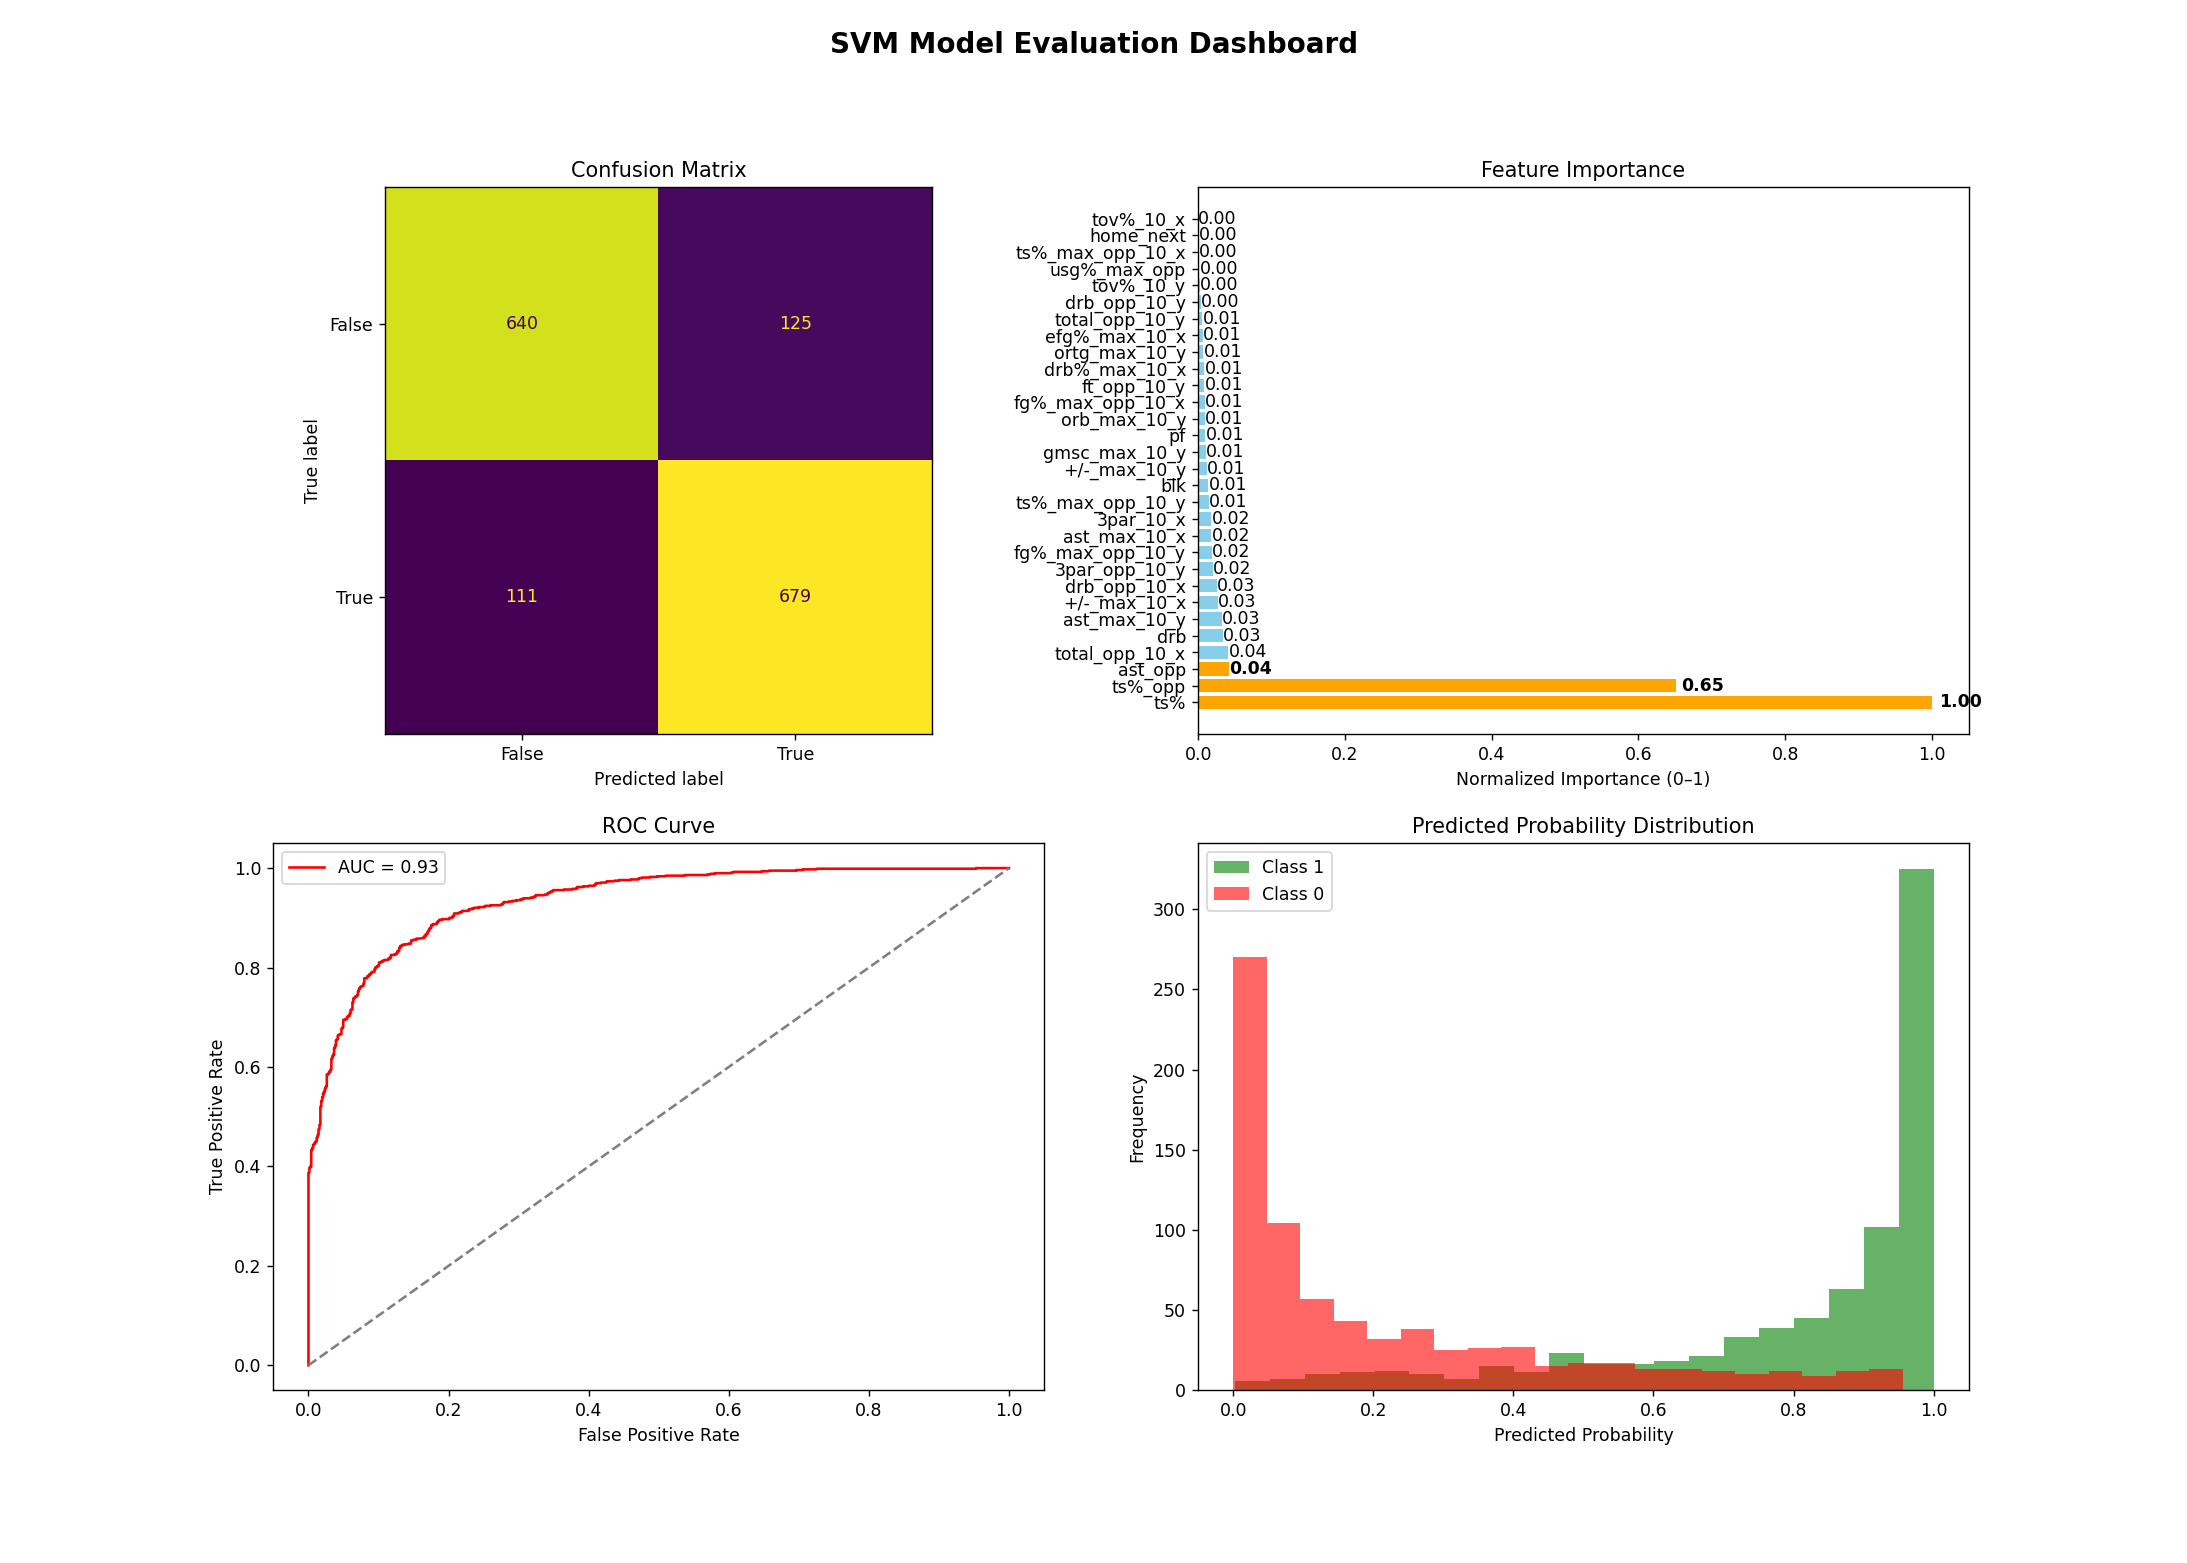

Model saved to saved_models\SVM Model.pkl


In [31]:
from sklearn import svm

model = svm.SVC(probability=True)
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "SVM Model")
save_model(model, predictors, feature_importance, model_name="SVM Model", folder="saved_models")

## Tree-Based

### Decision Tree
__Type__: Both  
__For__: Simple classification/regression  
__Pros__: East to interpret, handles non-linear data  
__Cons__: Overfits easily, unstable  

Note: 1980s; basis for modern ensembles

              precision    recall  f1-score   support

       False       0.78      0.76      0.77       765
        True       0.77      0.79      0.78       790

    accuracy                           0.78      1555
   macro avg       0.78      0.78      0.78      1555
weighted avg       0.78      0.78      0.78      1555



<IPython.core.display.Javascript object>


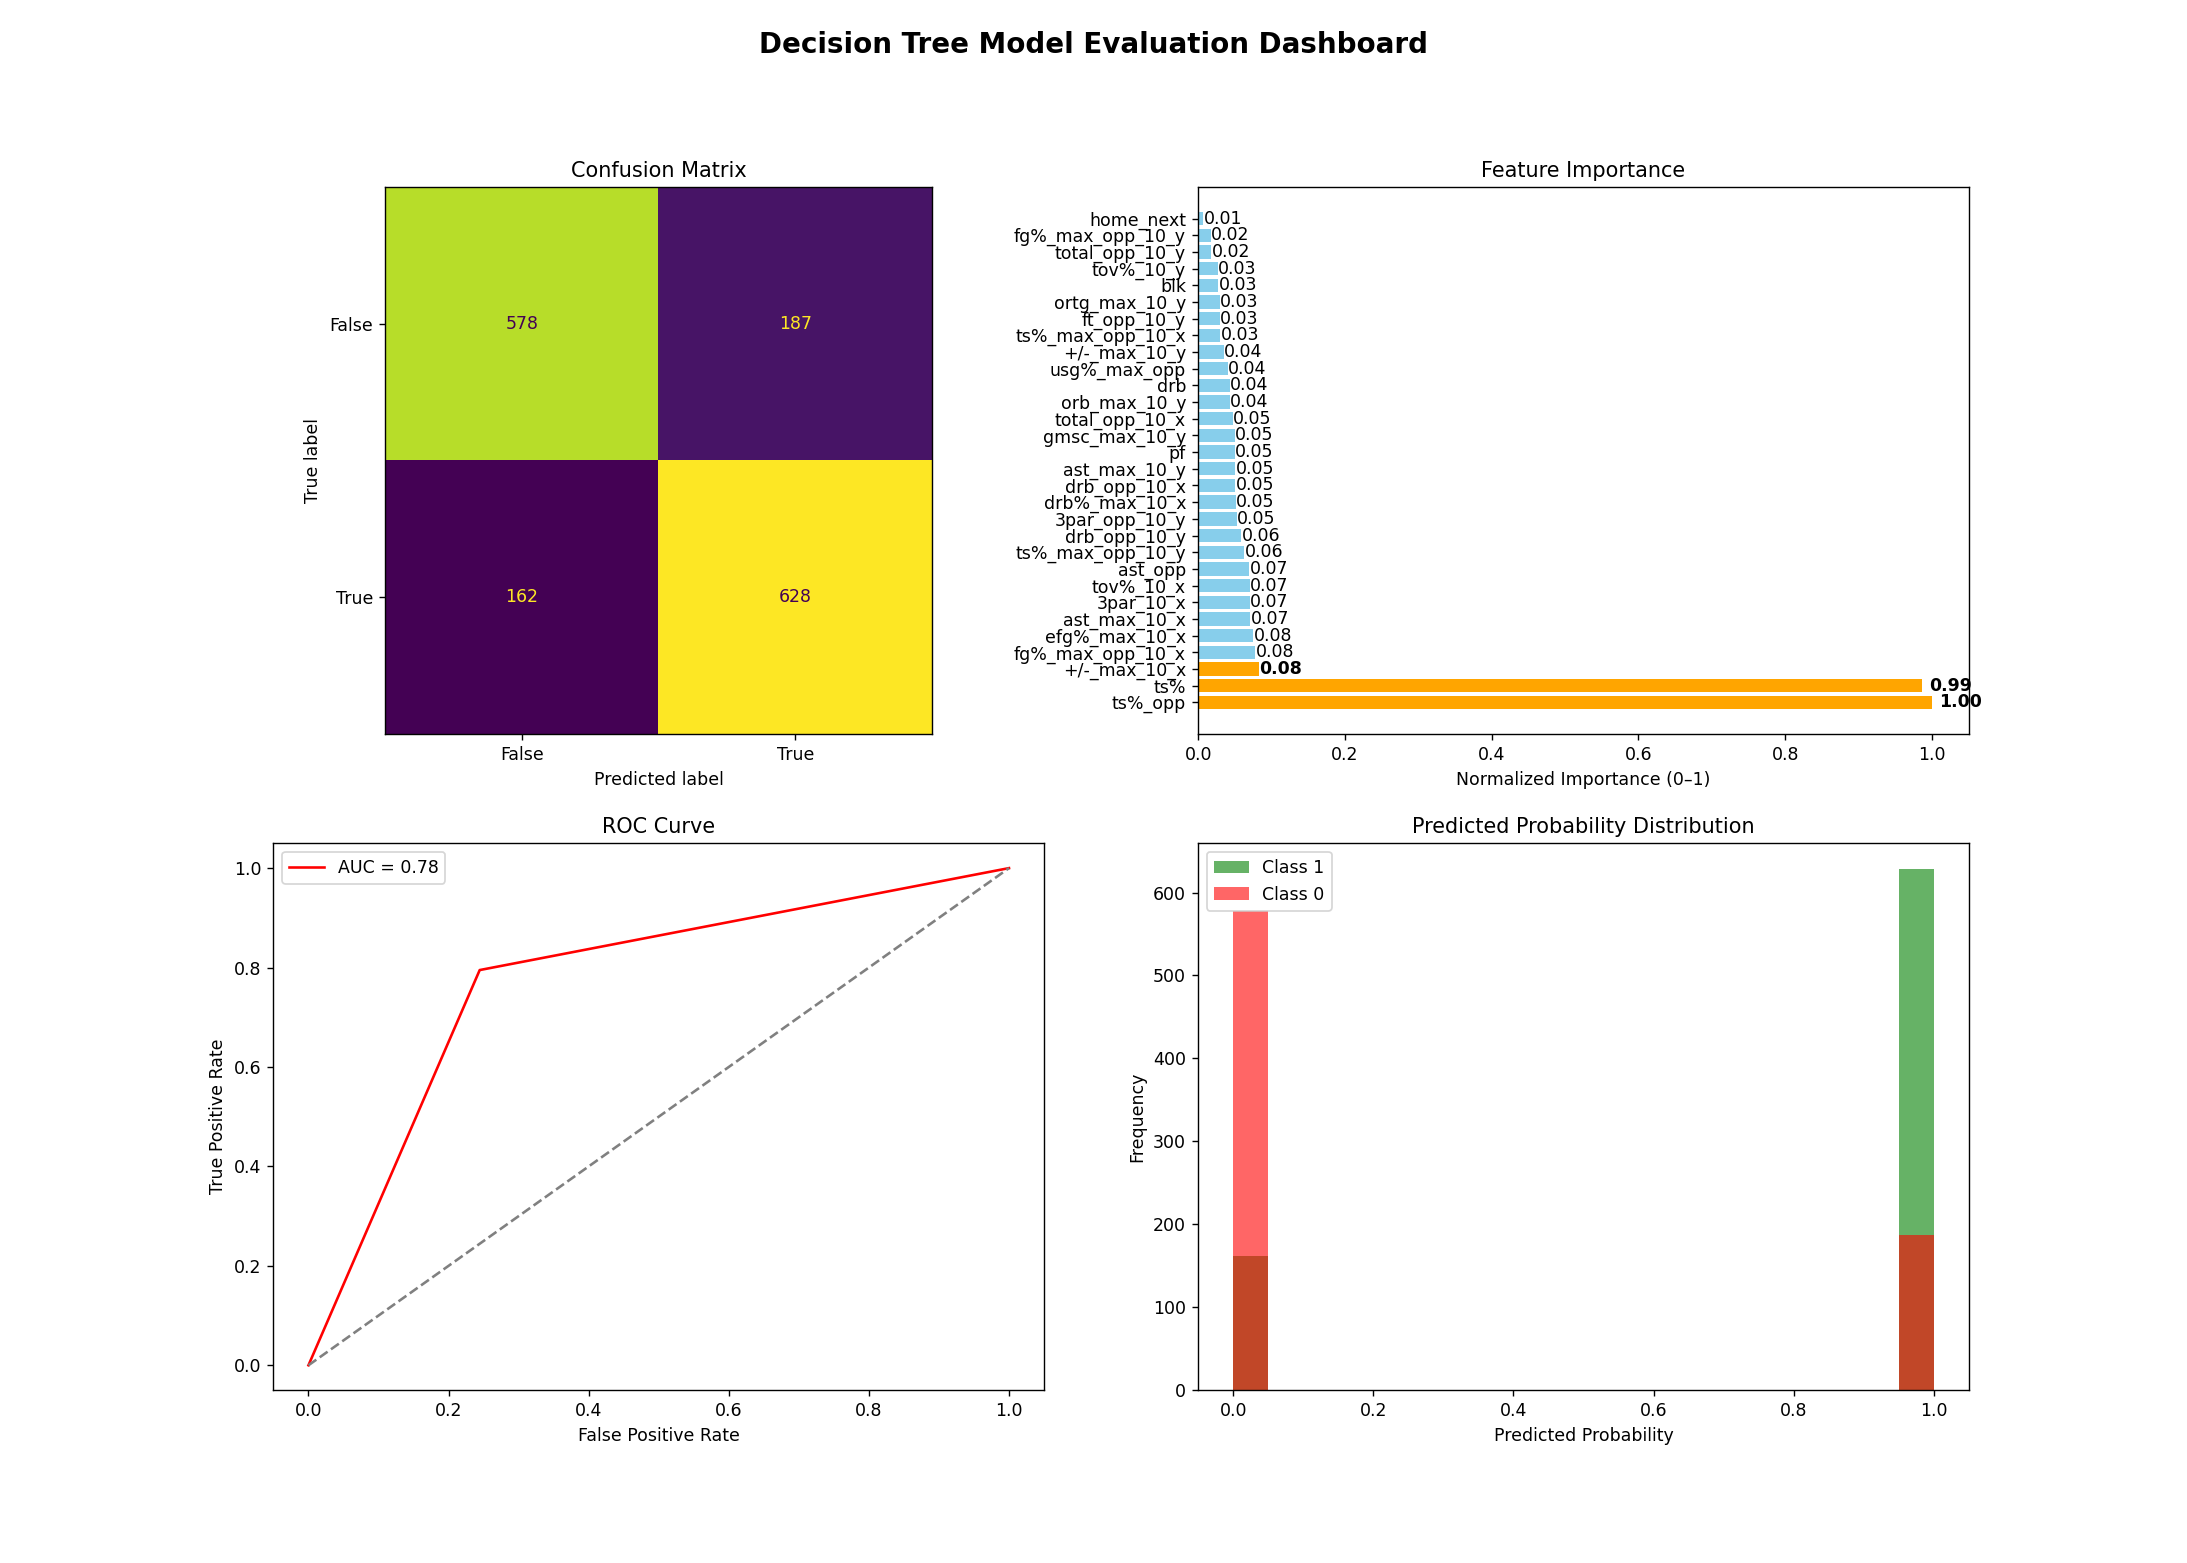

Model saved to saved_models\Decision Tree Model.pkl


In [32]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "Decision Tree Model")
save_model(model, predictors, feature_importance, model_name="Decision Tree Model", folder="saved_models")

### Random Forest
__Type__: Both  
__For__: General-purpose baseline  
__Pros__: Reduces overfitting, robust, good accuracy  
__Cons__: Slower, less interpretable  

Note: 2001 (Breiman); got-to tabular model

              precision    recall  f1-score   support

       False       0.82      0.79      0.81       765
        True       0.81      0.83      0.82       790

    accuracy                           0.81      1555
   macro avg       0.81      0.81      0.81      1555
weighted avg       0.81      0.81      0.81      1555



<IPython.core.display.Javascript object>


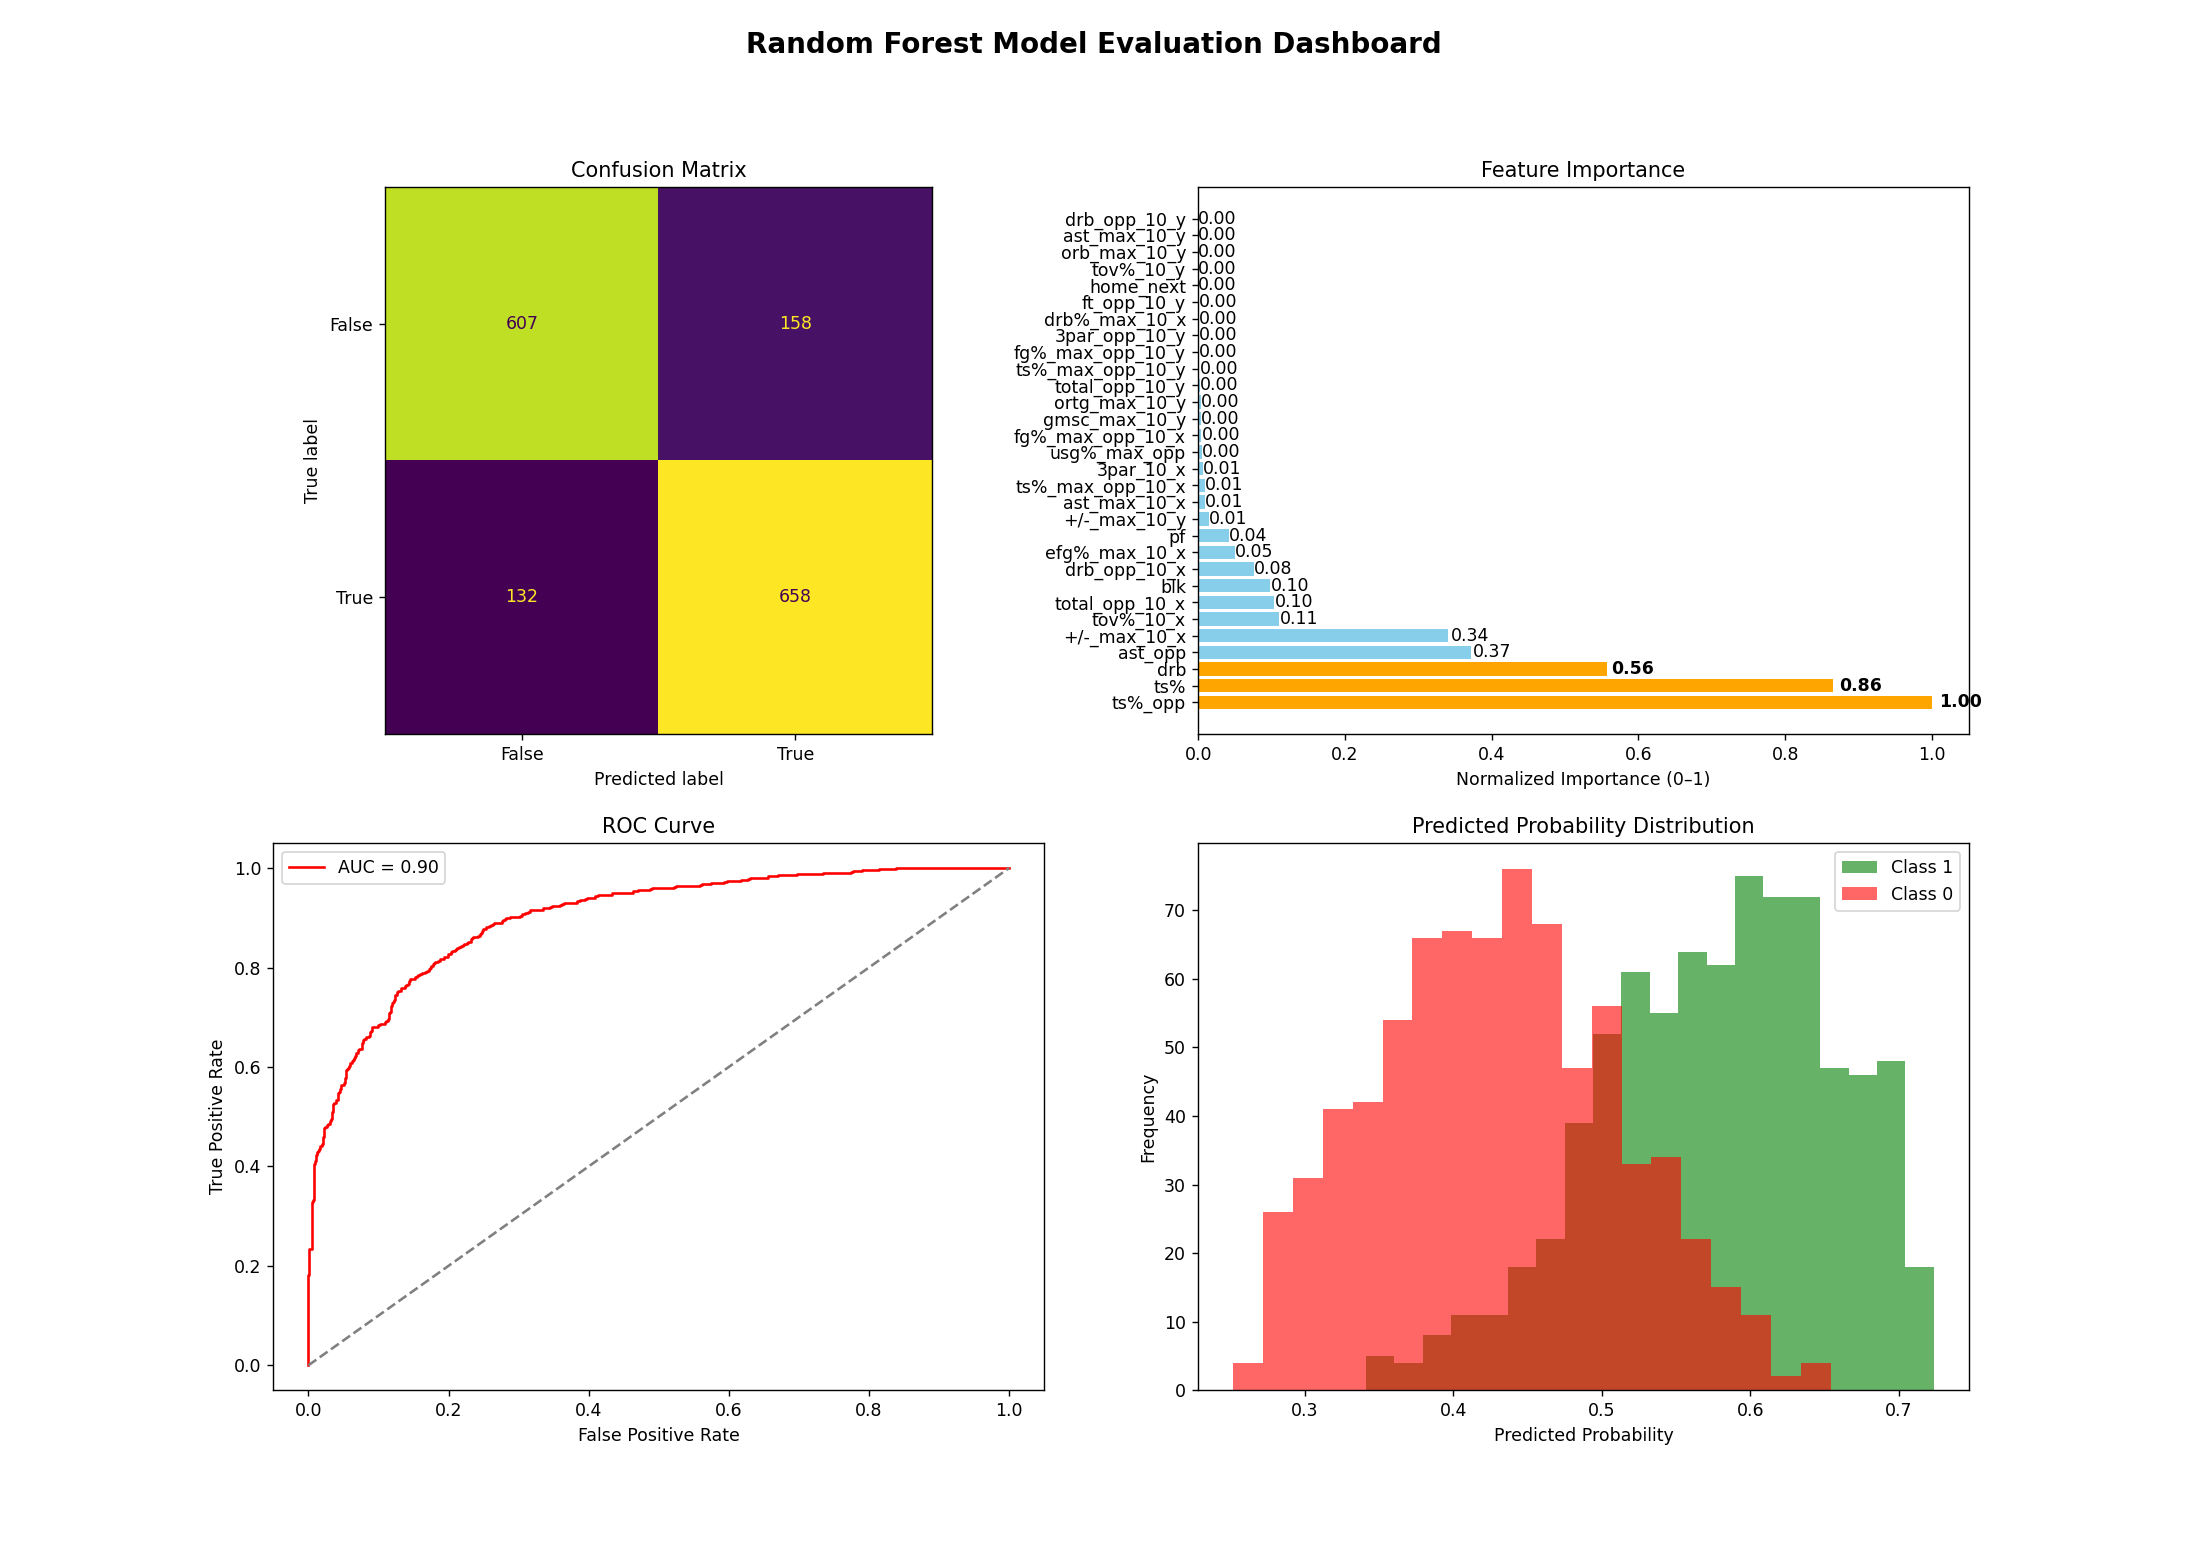

Model saved to saved_models\Random Forest Model.pkl


In [33]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=2, random_state=0)
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "Random Forest Model")
save_model(model, predictors, feature_importance, model_name="Random Forest Model", folder="saved_models")

### Gradient Boosting (XGBoost, LightGBM)
__Type__: Both  
__For__: Tabular, structured data (competition winner)  
__Pros__: High accuracy, feature importance  
__Cons__: Harder to tune, longer training  

Note: 2014-2017; top Kaggle performers

              precision    recall  f1-score   support

       False       0.84      0.82      0.83       765
        True       0.83      0.85      0.84       790

    accuracy                           0.83      1555
   macro avg       0.83      0.83      0.83      1555
weighted avg       0.83      0.83      0.83      1555



<IPython.core.display.Javascript object>


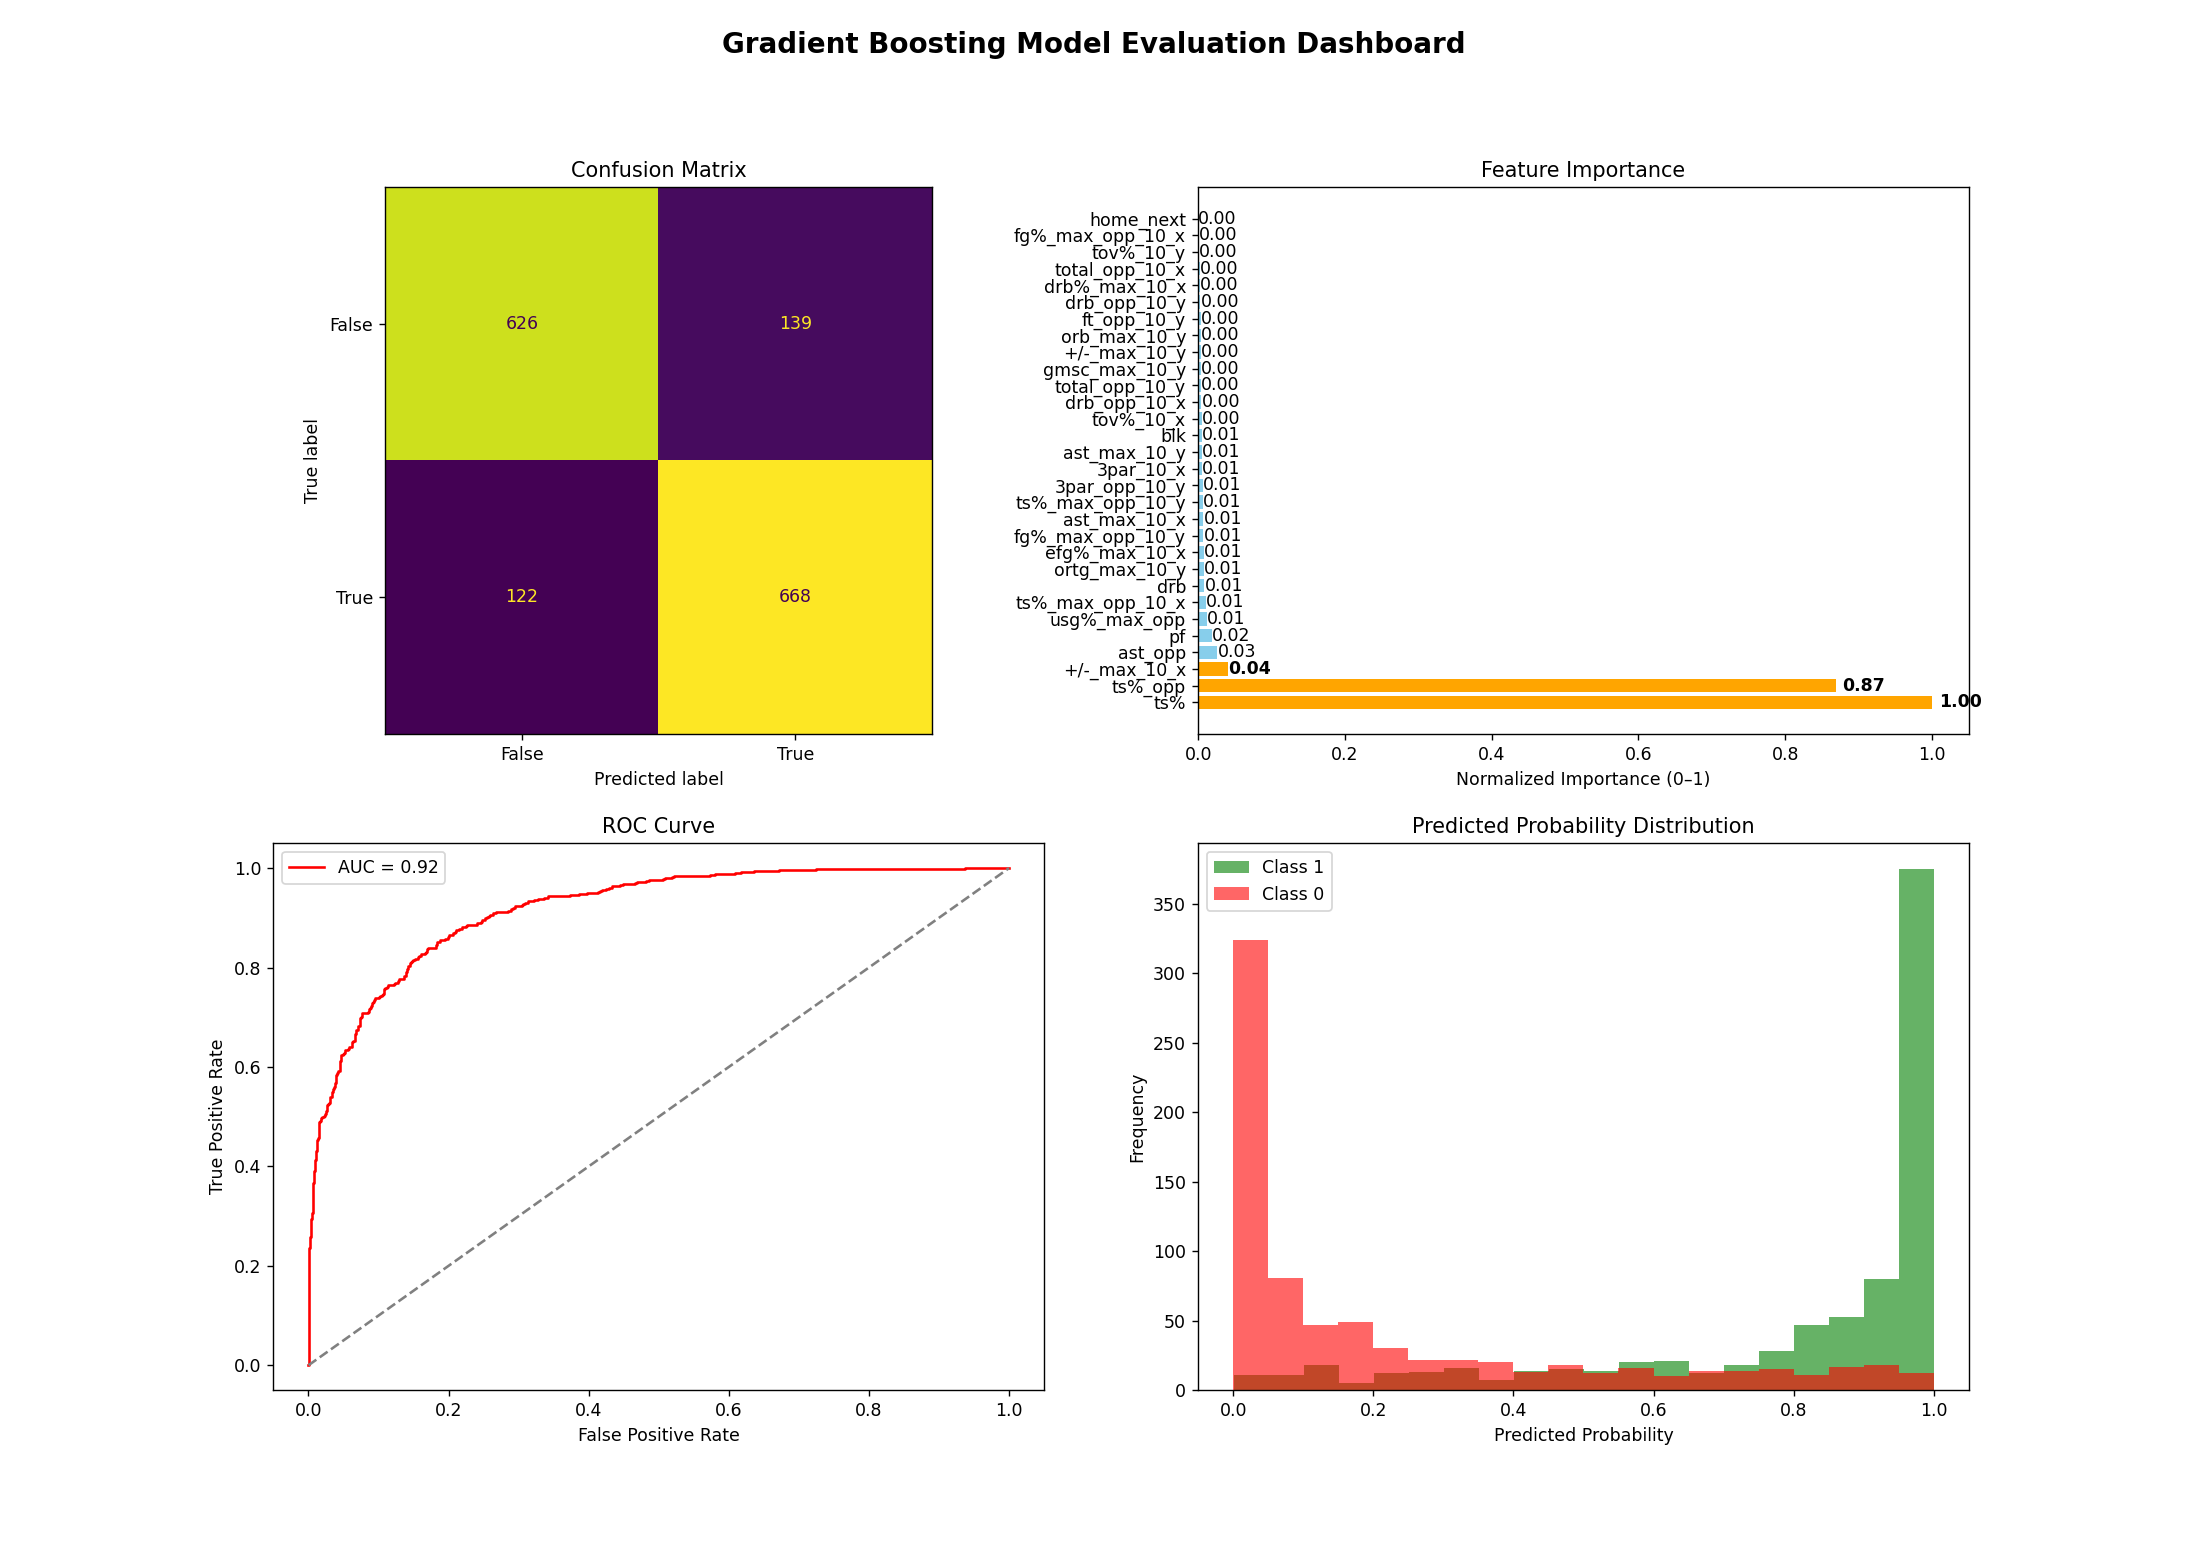

Model saved to saved_models\Gradient Boosting Model.pkl


In [34]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "Gradient Boosting Model")
save_model(model, predictors, feature_importance, model_name="Gradient Boosting Model", folder="saved_models")

In [35]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


[LightGBM] [Info] Number of positive: 1815, number of negative: 1812
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5861
[LightGBM] [Info] Number of data points in the train set: 3627, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500414 -> initscore=0.001654
[LightGBM] [Info] Start training from score 0.001654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

              precision    recall  f1-score   support

       False       0.83      0.83      0.83       765
        True       0.83      0.84      0.84       790

    accuracy                           0.83      1555
   macro avg       0.83      0.83      0.83      1555
weighted avg       0.83      0.83      0.83      1555



<IPython.core.display.Javascript object>


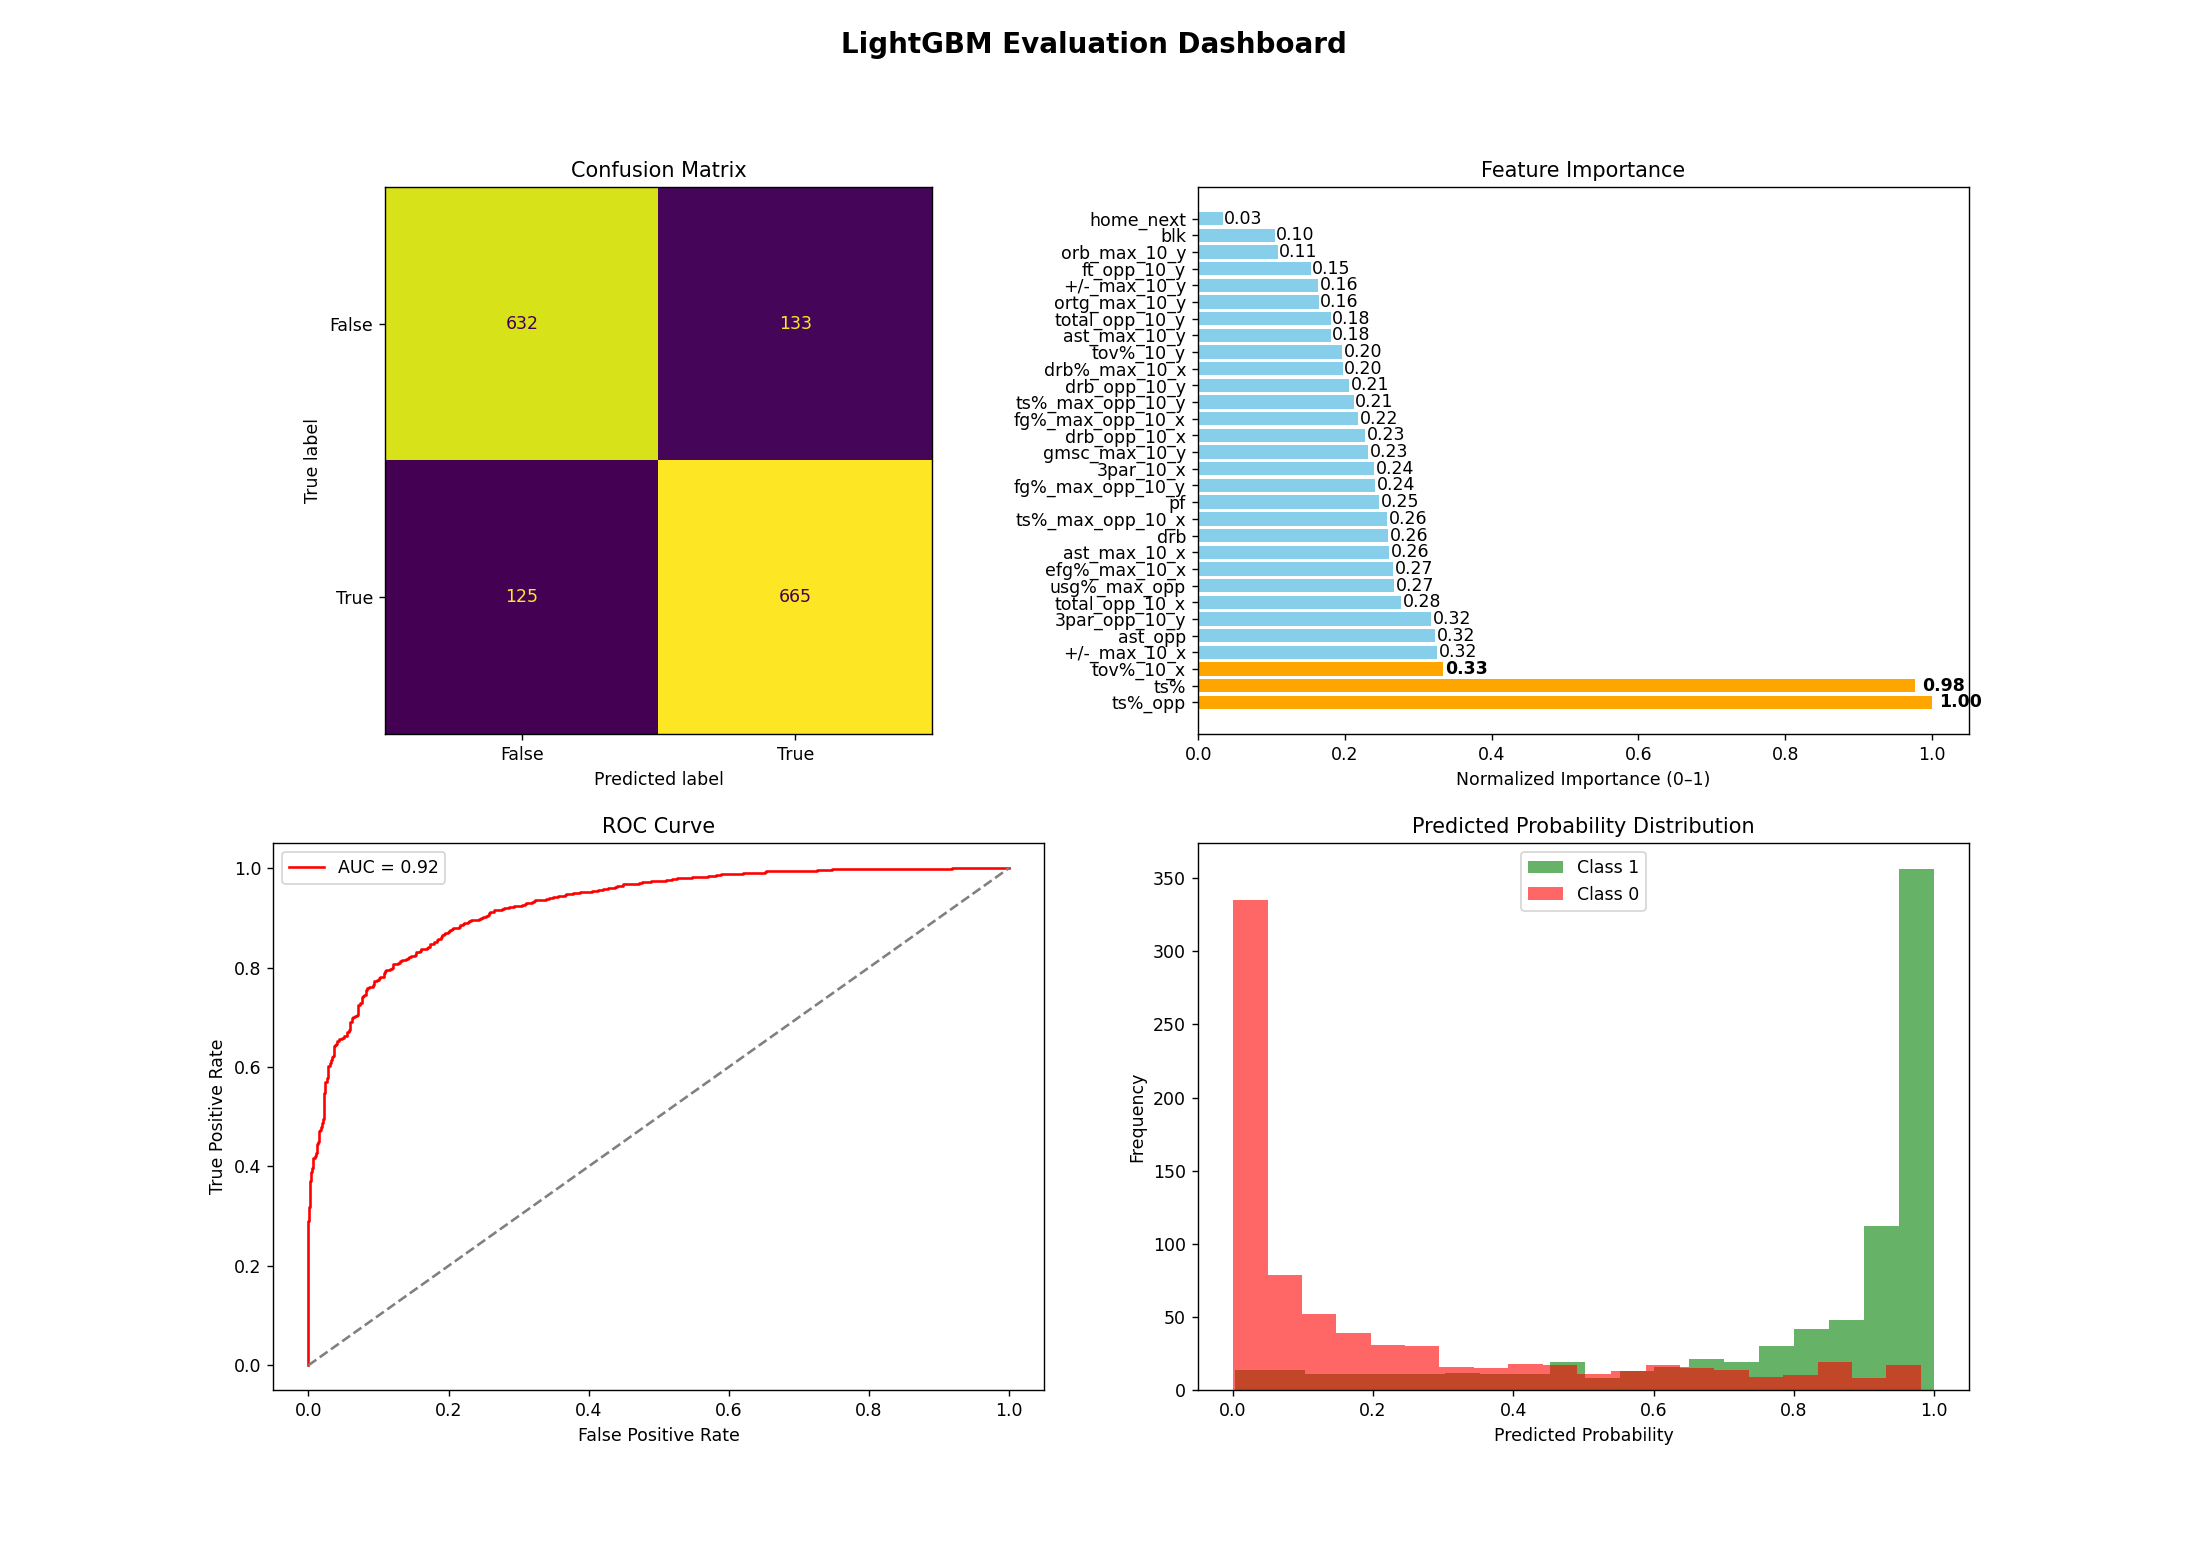

Model saved to saved_models\LightGBM.pkl


In [36]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "LightGBM")
save_model(model, predictors, feature_importance, model_name="LightGBM", folder="saved_models")

In [37]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


0:	total: 142ms	remaining: 1m 10s
100:	total: 371ms	remaining: 1.46s
200:	total: 596ms	remaining: 887ms
300:	total: 825ms	remaining: 545ms
400:	total: 1.05s	remaining: 261ms
499:	total: 1.28s	remaining: 0us
              precision    recall  f1-score   support

       False       0.85      0.83      0.84       765
        True       0.84      0.86      0.85       790

    accuracy                           0.85      1555
   macro avg       0.85      0.85      0.85      1555
weighted avg       0.85      0.85      0.85      1555



<IPython.core.display.Javascript object>


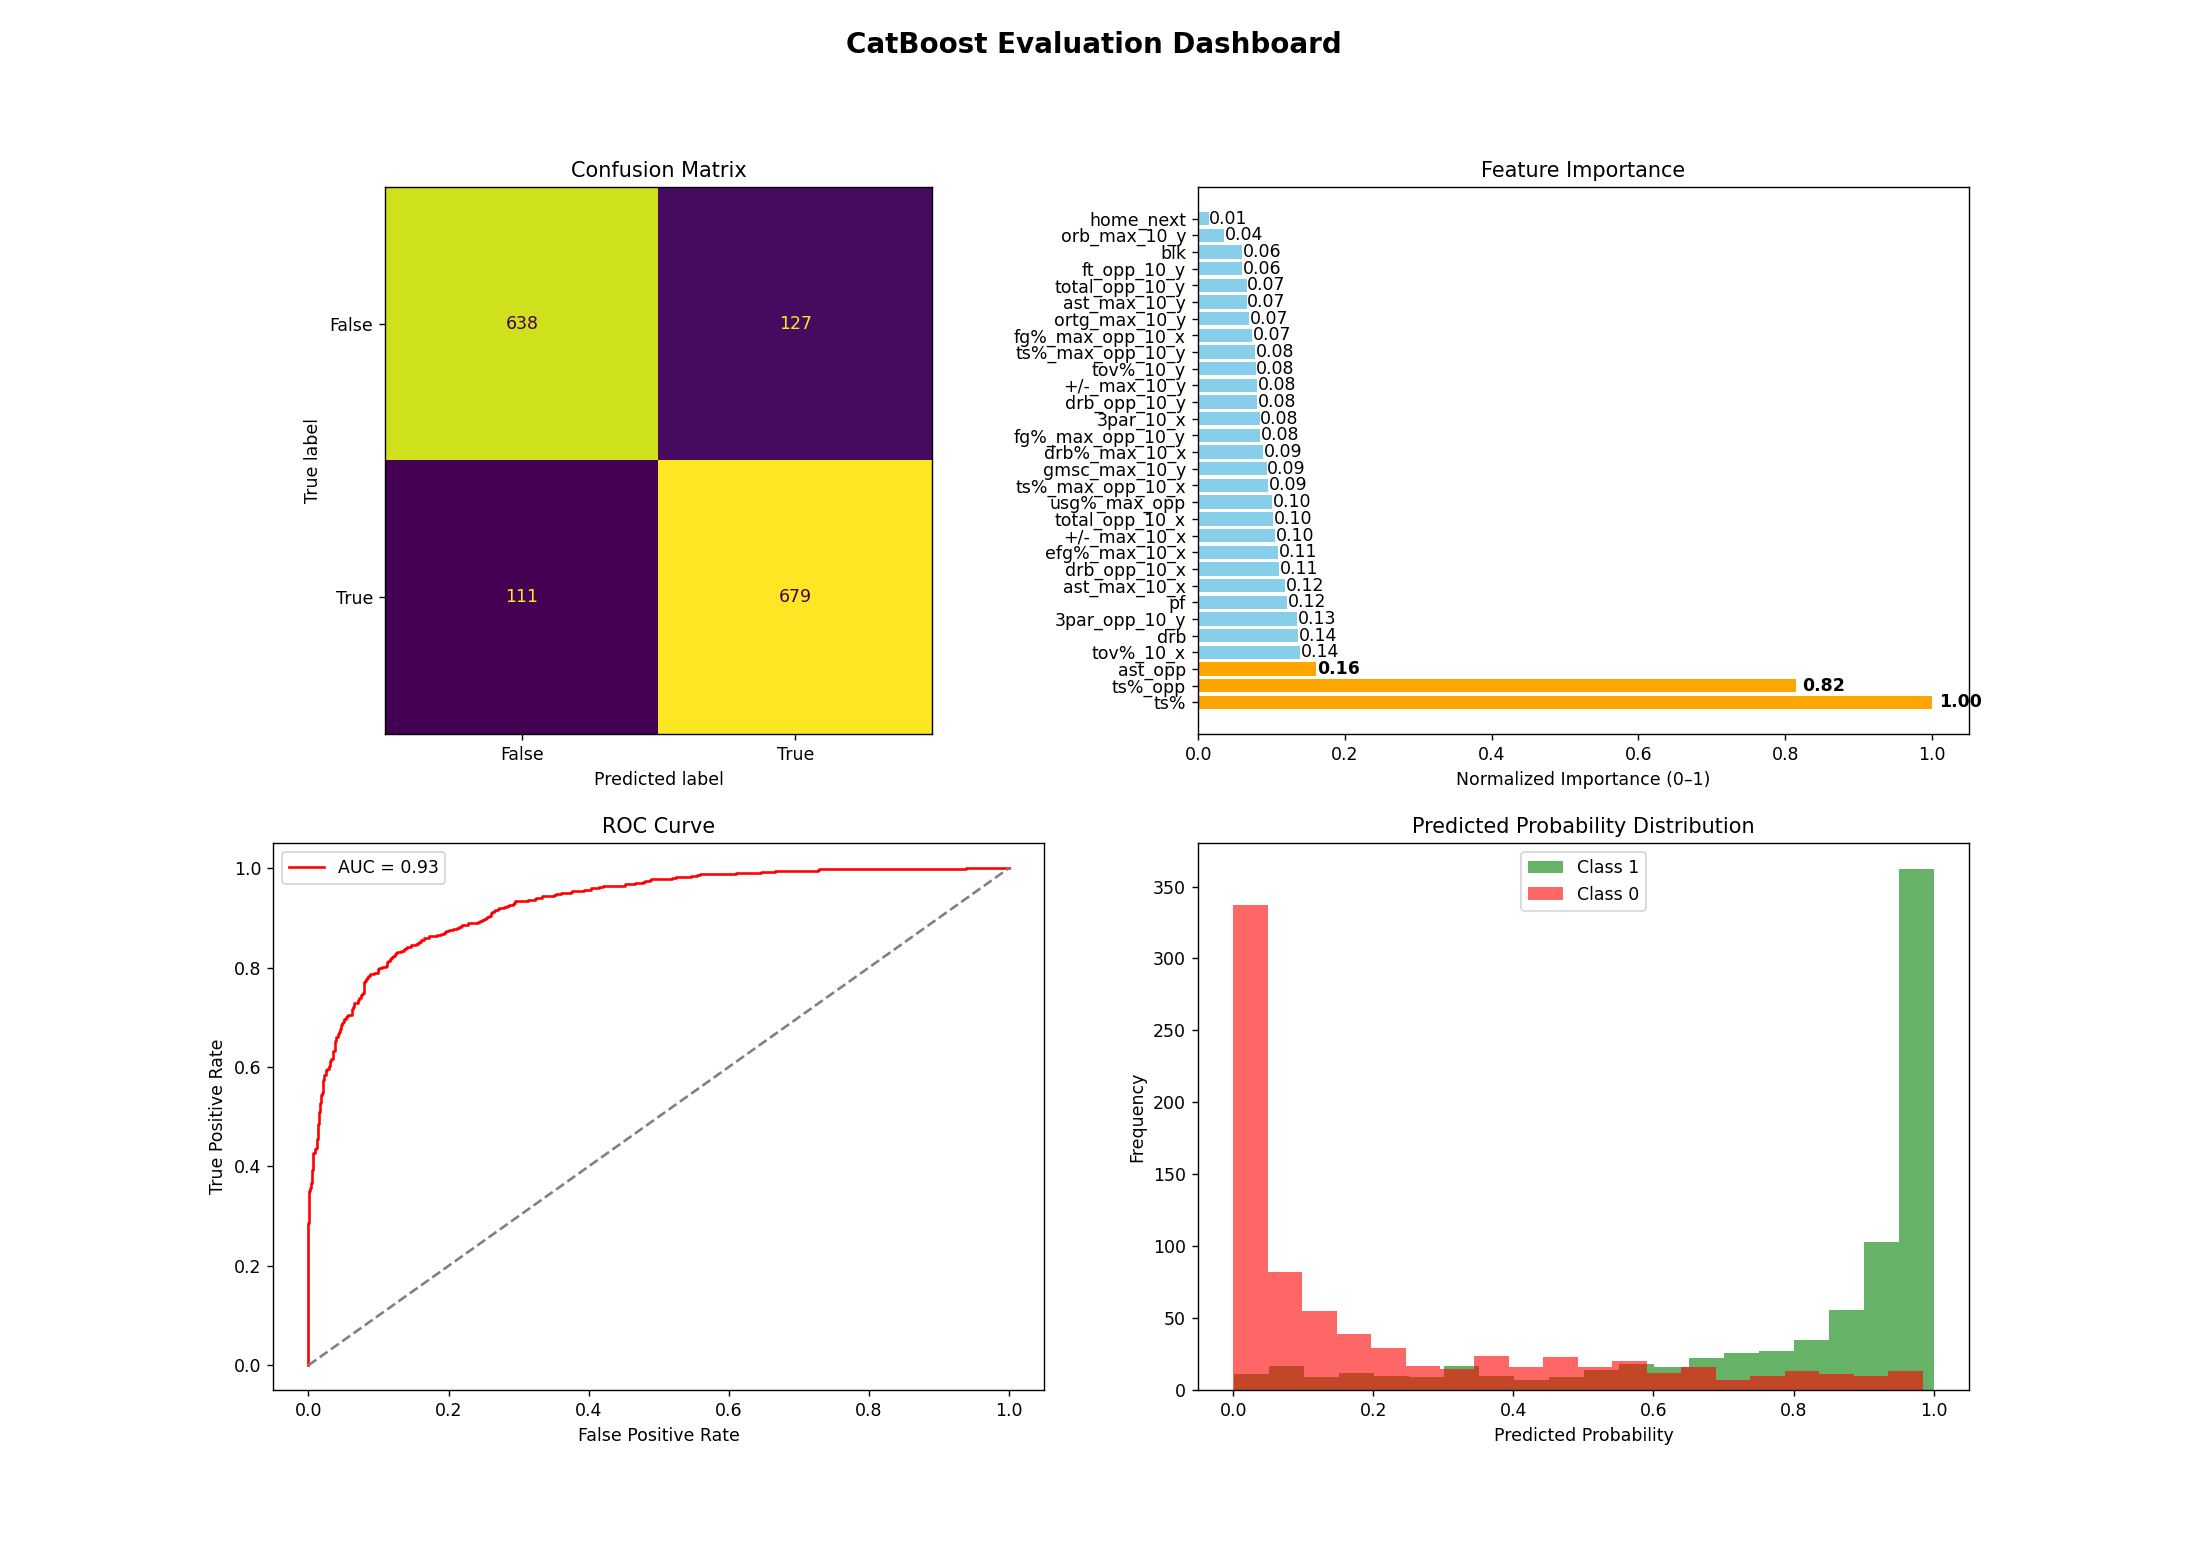

Model saved to saved_models\CatBoost.pkl


In [38]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "CatBoost")
save_model(model, predictors, feature_importance, model_name="CatBoost", folder="saved_models")

## Distance-based

### K-Nearest Neighbors
__Type__: Both  
__For__: Small, simple datasets  
__Pros__: No training, intuitive  
__Cons__: Slow with large data, sensitive to scaling  

Note: 1951; instance-based learning

              precision    recall  f1-score   support

       False       0.77      0.76      0.76       765
        True       0.77      0.77      0.77       790

    accuracy                           0.77      1555
   macro avg       0.77      0.77      0.77      1555
weighted avg       0.77      0.77      0.77      1555



<IPython.core.display.Javascript object>


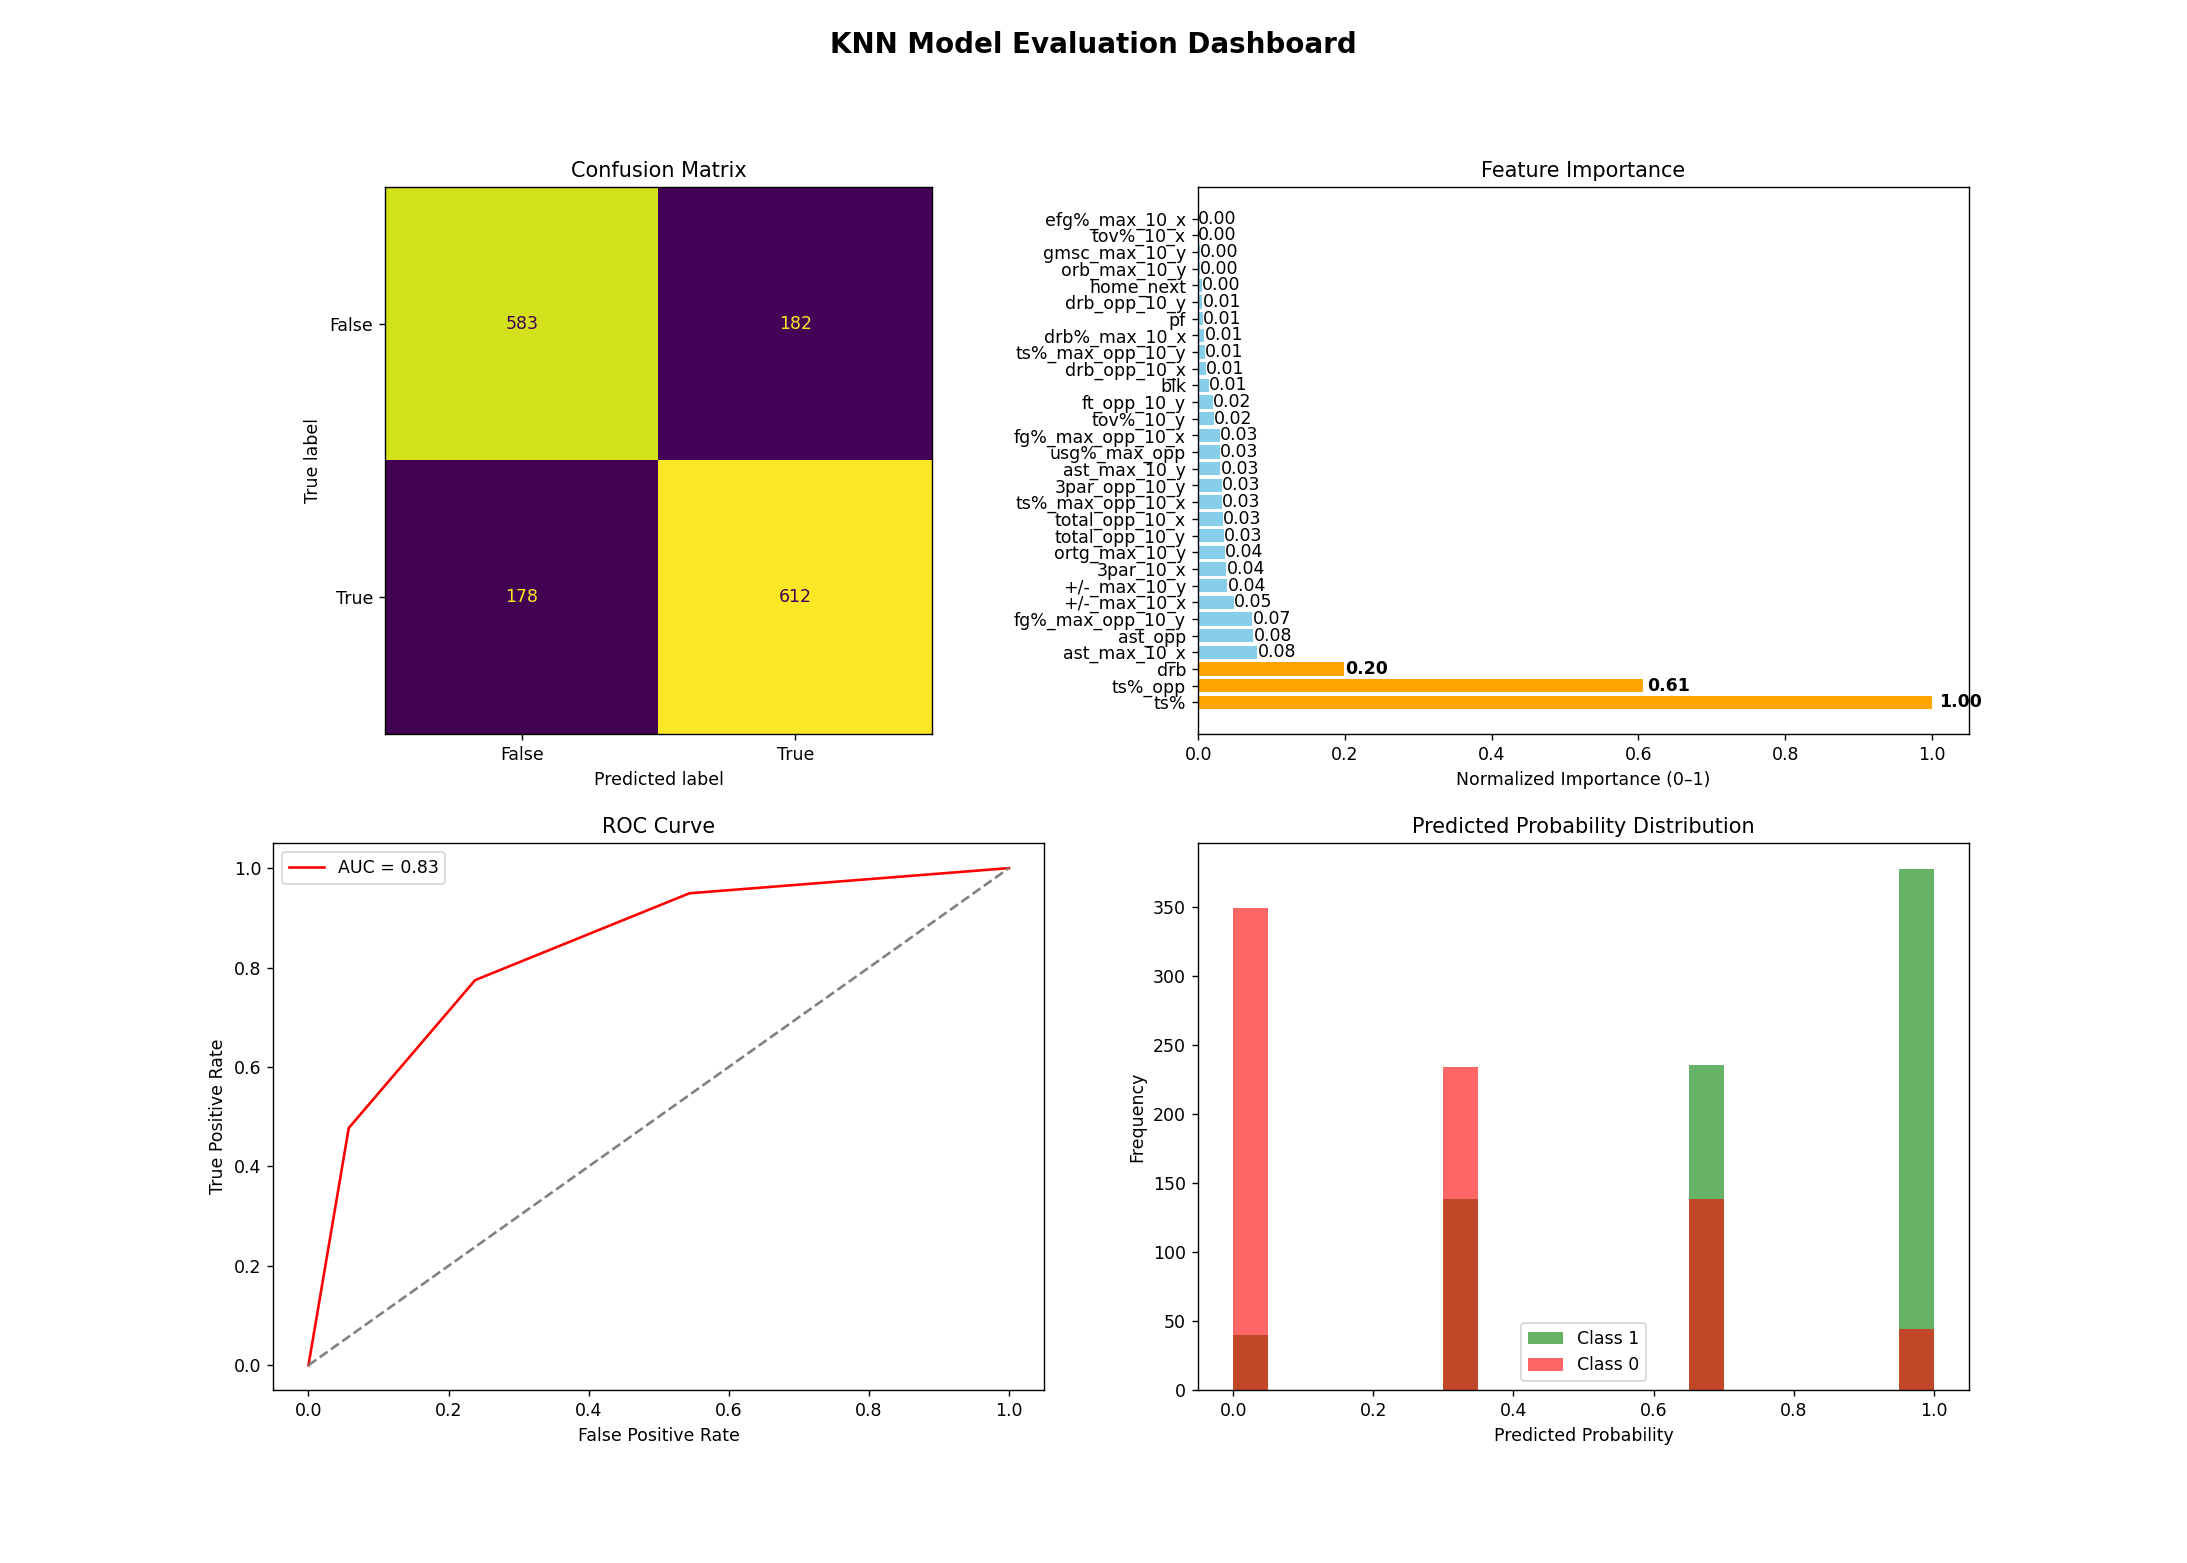

Model saved to saved_models\KNN Model.pkl


In [39]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "KNN Model")
save_model(model, predictors, feature_importance, model_name="KNN Model", folder="saved_models")

### K-Means Clustering
__Type__: Unsupervised  
__For__: Segmenting data into groups  
__Pros__: Simple, fast  
__Cons__: Requires k, sensitive to scale

Note: 1967; use as exploratory tool

<IPython.core.display.Javascript object>


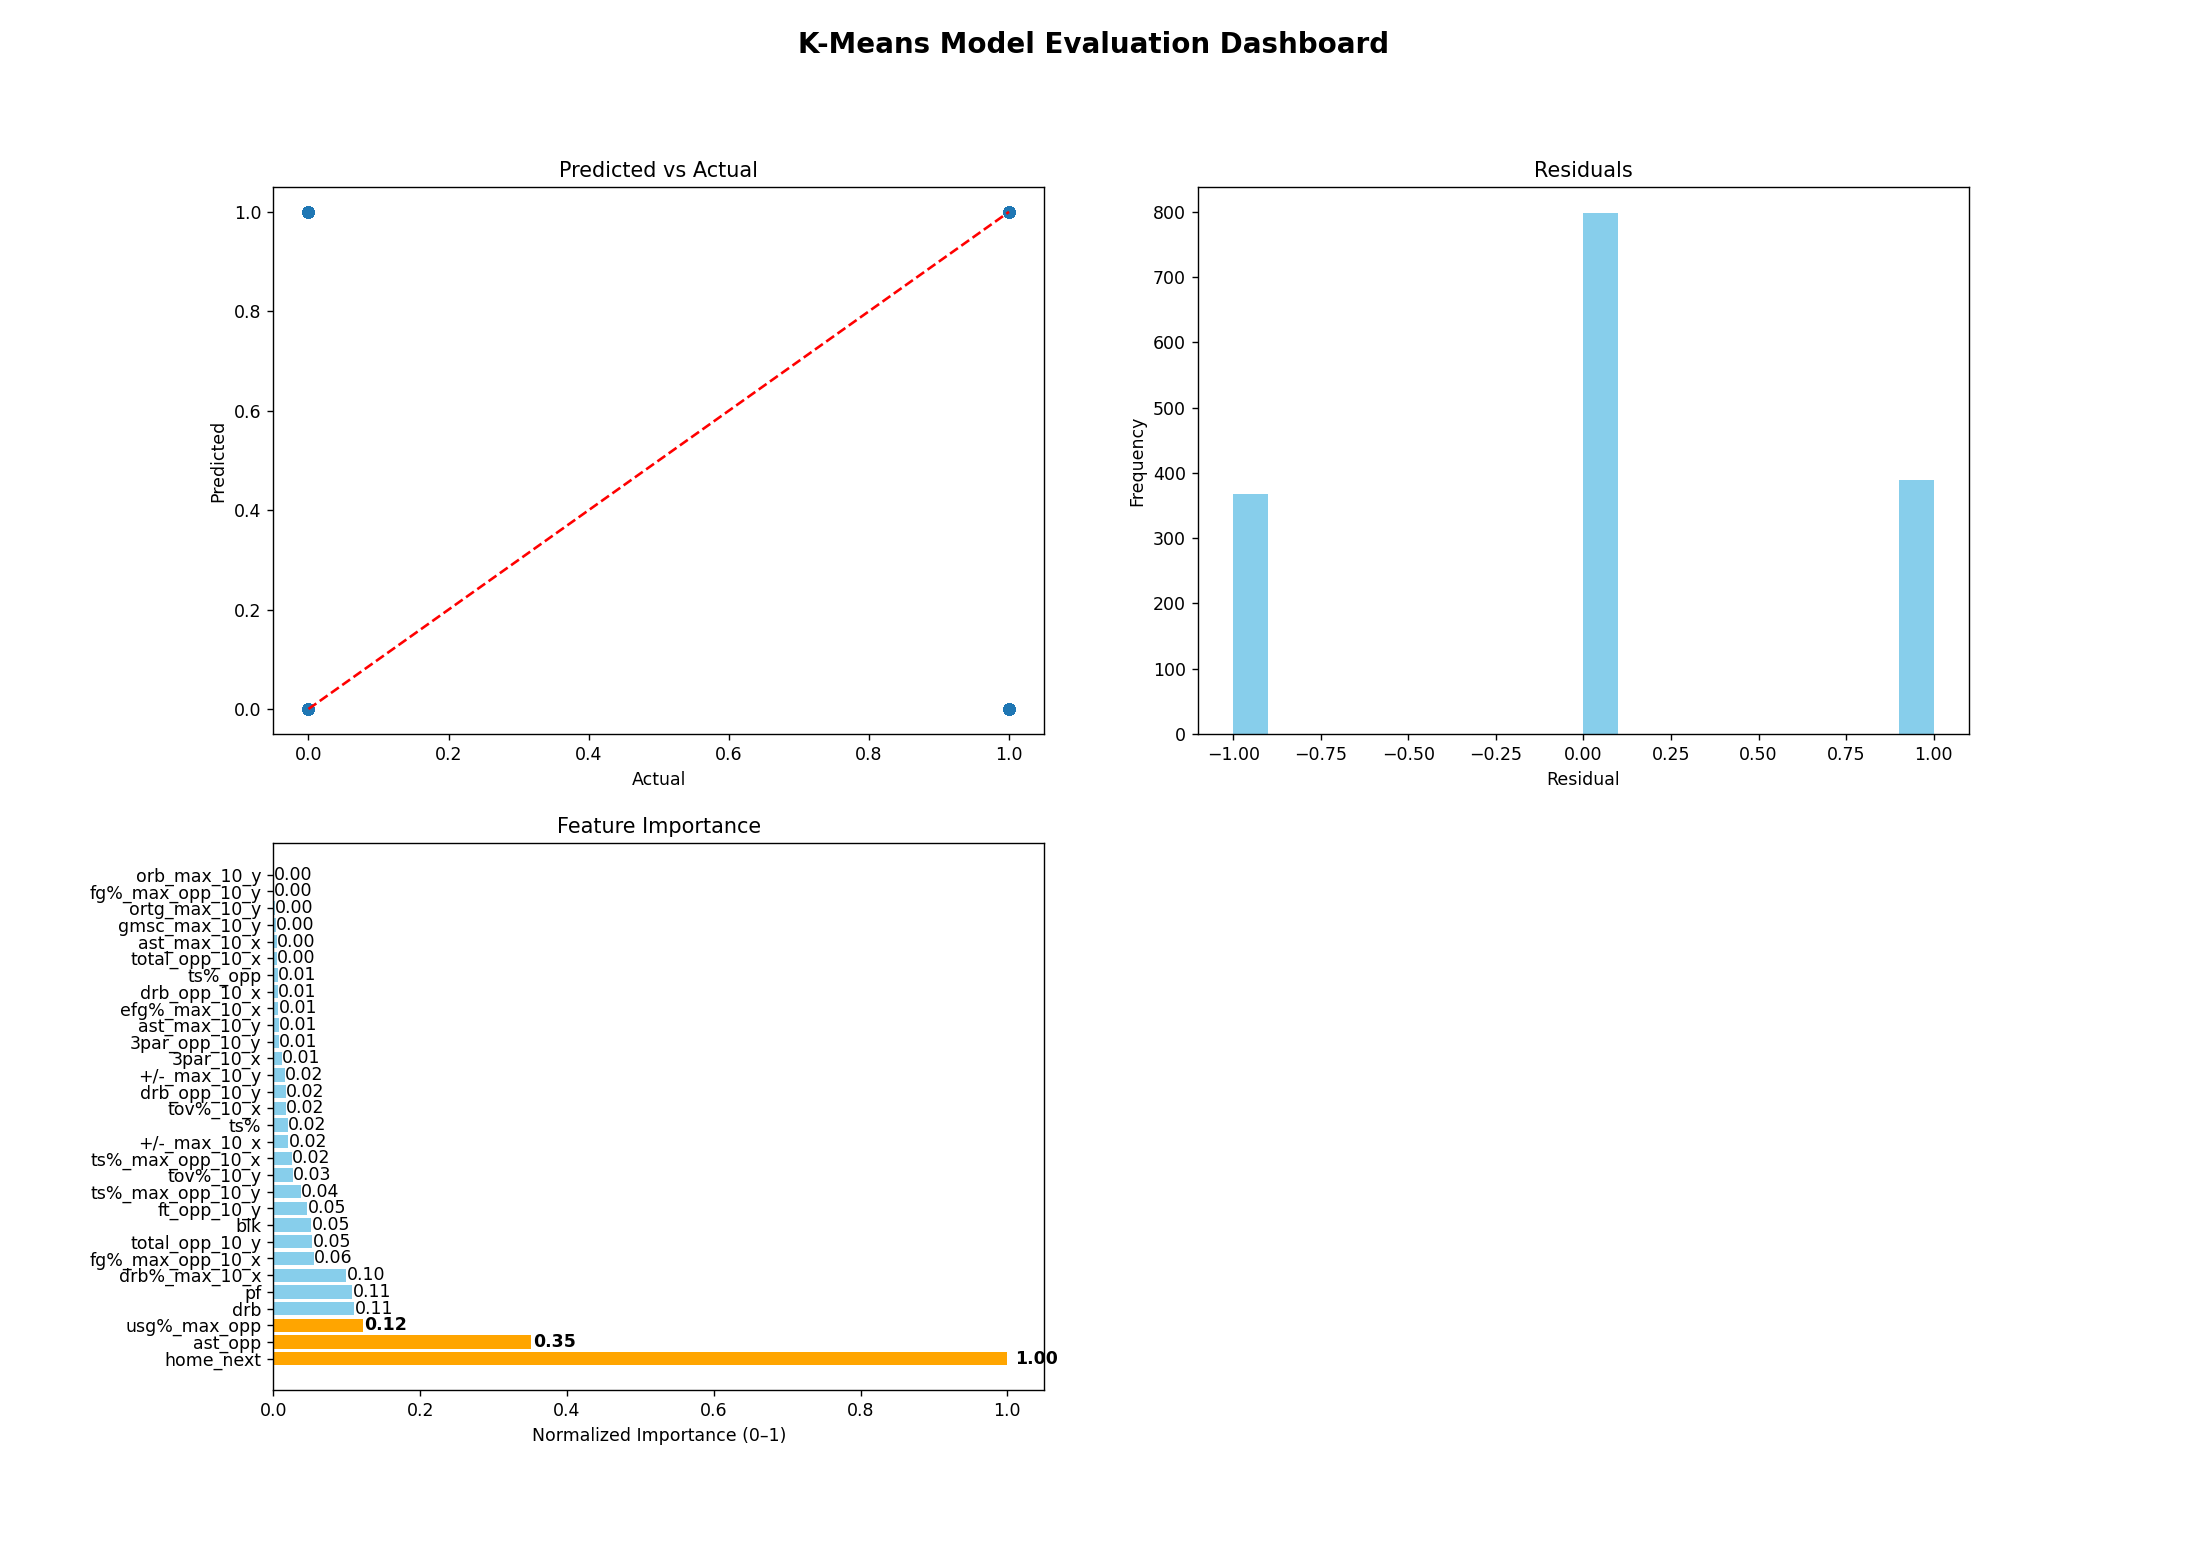

Model saved to saved_models\K-Means Model.pkl


In [40]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=0)
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "K-Means Model")
save_model(model, predictors, feature_importance, model_name="K-Means Model", folder="saved_models")

## Probabilistic

### Naive Bayes
__Type__: Classification  
__For__: Text, spam, sentiment  
__Pros__: Fast, probabilistic  
__Cons__: Strong independence assumption  

Note: 1950s; simple baseline for NLP

              precision    recall  f1-score   support

       False       0.84      0.82      0.83       765
        True       0.83      0.85      0.84       790

    accuracy                           0.83      1555
   macro avg       0.83      0.83      0.83      1555
weighted avg       0.83      0.83      0.83      1555



<IPython.core.display.Javascript object>


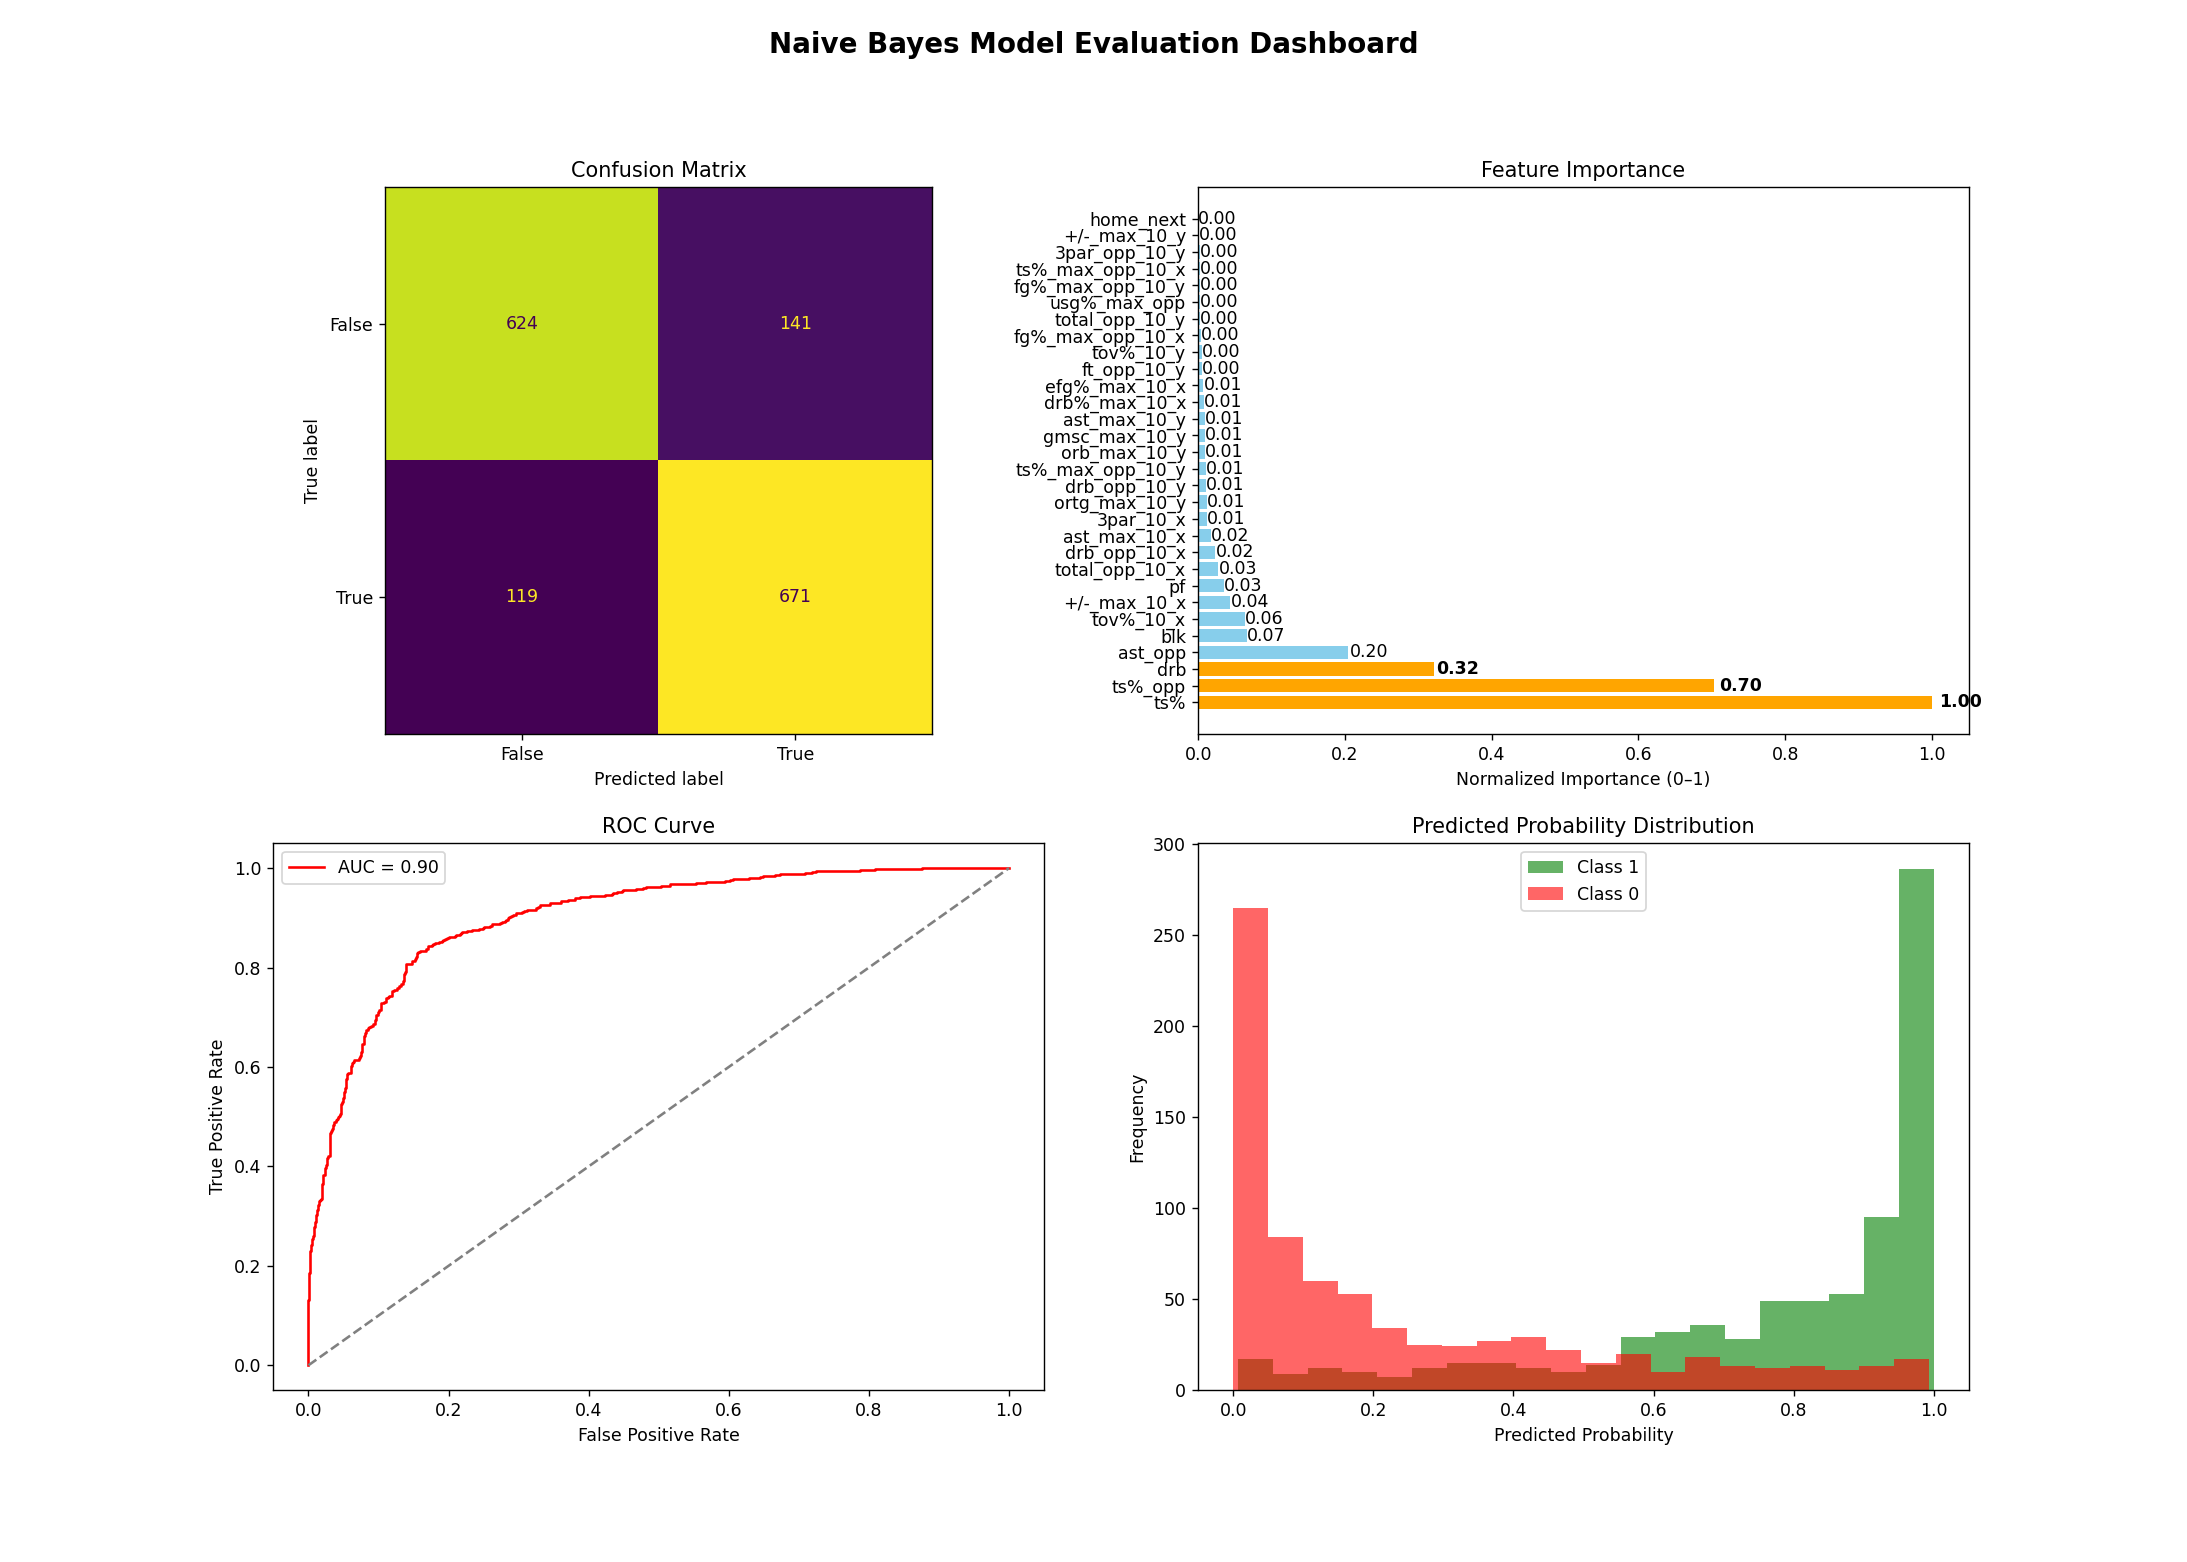

Model saved to saved_models\Naive Bayes Model.pkl


In [41]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "Naive Bayes Model")
save_model(model, predictors, feature_importance, model_name="Naive Bayes Model", folder="saved_models")

## Neural Networks
### Multi-Layered Perceptron (MLP)
__Type__: Both  
__For__: Complex patterns, non-linearity  
__Pros__: Powerful, flexible  
__Cons__: Needs a large amount of data, harder to interpret

Note: 1958 (Perceptron), reborn 2010s

              precision    recall  f1-score   support

       False       0.86      0.84      0.85       765
        True       0.85      0.87      0.86       790

    accuracy                           0.86      1555
   macro avg       0.86      0.86      0.86      1555
weighted avg       0.86      0.86      0.86      1555



<IPython.core.display.Javascript object>


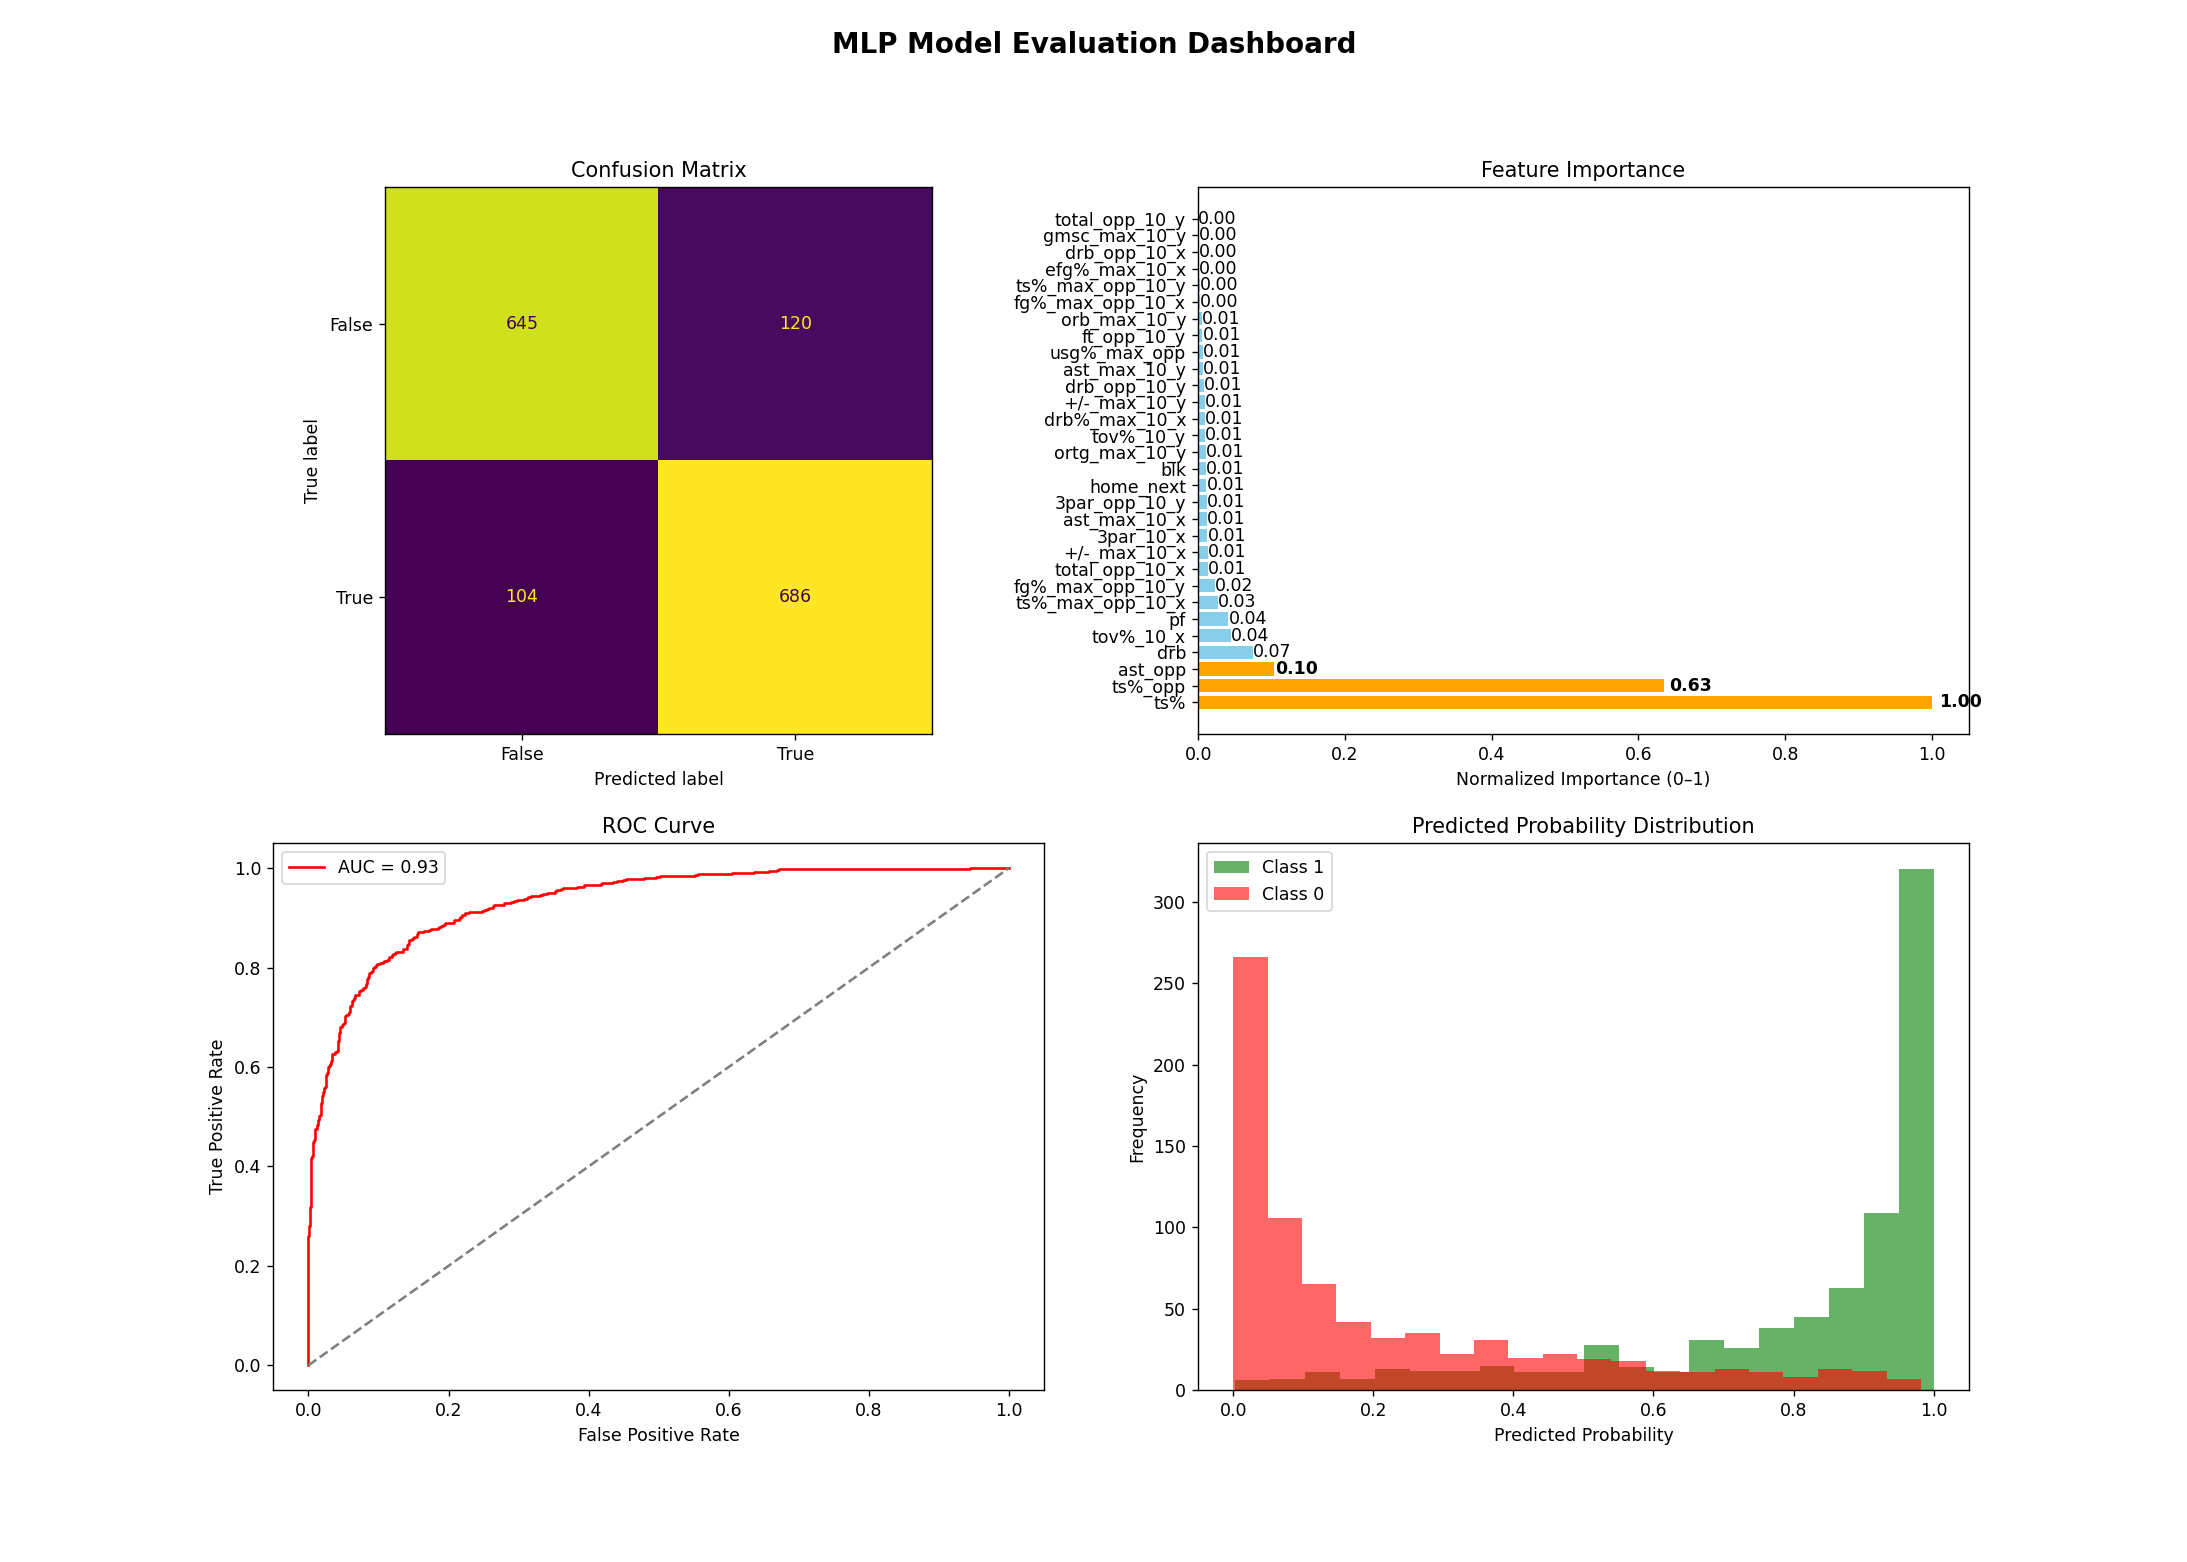

Model saved to saved_models\MLP Model.pkl


In [42]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=1, max_iter=300)
model, feature_importance = evaluation_dashboard(df, model, predictors, "won", "MLP Model")
save_model(model, predictors, feature_importance, model_name="MLP Model", folder="saved_models")

### Convolutional Neural Network (CNN)
__Type__: Classification (vision)  
__For__: Images, video, spatial data  
__Pros__: Learns features automatically  
__Cons__: Computationally heavy

Note: 1998-2012 (LeNet -> AlexNet revolution)

### Recurrent Neural Network (RNN / LSTM / GRU)
__Type__: Sequential  
__For__: Time series, text  
__Pros__: Captures sequence patterns  
__Cons__: Harder to train, vanishing gradients

Note: 1997 (LSTM), strong in NLP pre-transformers

### Transformers (BERT, GPT)
__Type__: NLP / Sequence  
__For__: Text, speech, time series  
__Pros__: State-of-the-art performance  
__Cons__: Data and compute hungry

Note: 2017 (Attention Is All You Need)

## Unsupervised

### DBSCAN / HDBSCAN
__Type__: Unsupervised  
__For__: Irregular clusters, noise  
__Pros__: Finds arbitrary shapes  
__Cons__: Needs tuning (eps, min_samples)

Note: 1966; good for density-based clustering

### Principal Component Analysis (PCA)
__Type__: Dimensionality Reduction  
__For__: Feature compression, visualisation  
__Pros__: Reduces noise, speeds training  
__Cons__: Loses interpretability

Note: 1930s-1960s; core unsupervised method